# Data Analysis 4 - Term Project
## Author: Márton Nagy

In [1]:
import pandas as pd
import numpy as np
import math
from pathlib import Path
from datetime import datetime as dt
from linearmodels import PanelOLS
from plotnine import *
import statsmodels.formula.api as smf
from stargazer.stargazer import Stargazer
import dill
import graphviz

import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

Importing the raw data file on EU fundings, as scraped by Mihaly Orsos (raw file downloaded from Mihaly Orsos's [GitHub](https://github.com/misrori/eu_love)).

In [2]:
eu_funding = pd.read_excel(Path('data', 'all_eu_money.xlsx'))

In [3]:
eu_funding.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 496650 entries, 0 to 496649
Data columns (total 18 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   fejlesztesi_program_nev  496650 non-null  object 
 1   forras                   470196 non-null  object 
 2   kiiras_eve               8627 non-null    float64
 3   op_kod                   496650 non-null  object 
 4   konstrukcio_nev          496650 non-null  object 
 5   konstrukcio_kod          496650 non-null  object 
 6   palyazo_neve             496650 non-null  object 
 7   projekt_cime             326714 non-null  object 
 8   megval_regio_nev         494882 non-null  object 
 9   megval_megye_nev         494882 non-null  object 
 10  kisterseg_nev            490058 non-null  object 
 11  helyseg_nev              494834 non-null  object 
 12  tam_dont_datum           496650 non-null  object 
 13  megitelt_tamogatas       496424 non-null  float64
 14  id_p

Dropping observations with either no municipality name or no funding data.

In [5]:
eu_funding = eu_funding[(eu_funding['helyseg_nev'].notna()) & eu_funding['megitelt_tamogatas'].notna()]

Converting to date and extracting the year for aggregation later.

In [6]:
eu_funding['tam_dont_datum'] = pd.to_datetime(eu_funding['tam_dont_datum'],format= '%Y.%m.%d')

In [7]:
eu_funding['year'] = eu_funding['tam_dont_datum'].dt.year

Cleaning up the municipality names:

- some included city parts in brackets -> removing that;
- filtering out when the municipality name is actually an indicator for missing vale;
- some included city parts seperated by dashes (either with spaces before the dash or not) -> removing that.

In [8]:
eu_funding['muni'] = eu_funding['helyseg_nev'].str.split(r' \(').str[0]
eu_funding = eu_funding[eu_funding['muni'] != r' _Nincs megadva helység']
eu_funding['muni'] = eu_funding['muni'].str.replace(' ', '')

In [9]:
eu_funding['muni'] = eu_funding['muni'].str.split('-').str[0]

My other datasets do not have district level data on the capital, so I rename these to simply Budapest.

In [10]:
eu_funding['muni'] = eu_funding['muni'].apply(lambda x: 'Budapest' if x[0:8] == 'Budapest' else x)

I aggregate the data by municipality and year to have a long format table.

In [11]:
eu_funding_panel = (
    eu_funding
    .groupby(by = ['muni', 'year'], as_index=False)
    .aggregate(sum_funding = ('megitelt_tamogatas', 'sum'))
    .sort_values(by = ['muni', 'year'], ascending = [True, True])
)

In [12]:
eu_funding_panel.columns = ['muni', 'year', 'eu_funding']

In [13]:
eu_funding_panel.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37440 entries, 0 to 37439
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   muni        37440 non-null  object 
 1   year        37440 non-null  int32  
 2   eu_funding  37440 non-null  float64
dtypes: float64(1), int32(1), object(1)
memory usage: 731.4+ KB


It turns out that some funding relates to multiple cities at once. To resolve this, I decided to to allocate a share of the EU funding to each included municipality in proportion to their population share (or in other words, by adding the joint per-capita funding).

In [14]:
eu_funding_panel[eu_funding_panel['muni'].str.contains(',')]

,muni,year,eu_funding
76,"Abaújkér,Abaújalpár",2019,147600000.0
2046,"Balatonszőlős,Balatonfüred",2016,93204444.0
2047,"Balatonszőlős,Balatonfüred",2017,48218045.0
2048,"Balatonszőlős,Balatonfüred",2018,35317460.0
2049,"Balatonszőlős,Balatonfüred",2019,35298430.0
...,...,...,...
36904,"Újbarok,Szár",2019,16580000.0
36905,"Újbarok,Szár",2023,25000000.0
36974,"Újireg,Iregszemcse",2020,25000000.0
37099,"Újsolt,Solt",2021,98000000.0


In [15]:
eu_funding_panel["group_id"] = eu_funding_panel.index
eu_funding_panel["muni"] = eu_funding_panel["muni"].str.split(",")
eu_funding_panel = eu_funding_panel.explode("muni", ignore_index=True)

I include a flag indicating if a municipality have received in a certain year some funding jointly with other municipalities. The flag will be added to the panel set later.

In [16]:
flagger = eu_funding_panel.group_id.value_counts()
flagger = list(flagger[flagger > 1].index)
flagger = eu_funding_panel[eu_funding_panel['group_id'].isin(flagger)][['muni', 'year']]
flagger['multi_muni_funding_flag'] = 1

As my possible confounder variables are in seperate Excel files, I create a function to extract and transform their values into an appropriate format.

In [17]:
def get_long_teir_data(path, value_name):
    df = pd.read_excel(path)
    # drop footers
    df = df[df['kod'].notna()]
    # get column names (years)
    new_cols = ['muni', 'code'] + [c[0:4] for c in list(df.columns)[2:]]
    df.columns = new_cols

    #clean up muni names
    df['muni'] = df['muni'].str.split(r' \*').str[0]
    
    # melt to long
    df_long = df.melt(id_vars = ['muni', 'code'], 
                  var_name = 'year', 
                  value_name = value_name)
    df_long['year'] = df_long['year'].astype(int)

    df_long.drop(columns = ['code'], inplace = True)
    return df_long

In [18]:
income = get_long_teir_data(Path('data', 'teir_szja_base.xlsx'), 'income')
unemp = get_long_teir_data(Path('data', 'teir_unemployment.xlsx'), 'unemp')
pop = get_long_teir_data(Path('data', 'teir_population.xlsx'), 'pop')
pop_dense = get_long_teir_data(Path('data', 'teir_pop_density.xlsx'), 'pop_dense')
ind_empl = get_long_teir_data(Path('data', 'teir_industry_employment.xlsx'), 'ind_empl')
agr_empl = get_long_teir_data(Path('data', 'teir_agric_employment.xlsx'), 'agr_empl')
heigh_prest_empl = get_long_teir_data(Path('data', 'teir_heigh_prest_employment.xlsx'), 'heigh_prest_empl')
pop_15_64_m = get_long_teir_data(Path('data', 'teir_15_64_pop_male.xlsx'), 'pop_15_64_m')
pop_15_64_f = get_long_teir_data(Path('data', 'teir_15_64_pop_female.xlsx'), 'pop_15_64_f')

Now let's compare the municipalities in our EU funding panel and the municipalities in one of our TEIR set (which is an official source). It turns out, that there are still some municipalities which are not present in the official source. It turns out, that these are either parts of larger cities, or there was simply a spelling mistake. I cleaned these up by manually constructing a look-up dictionary for the correct municipalities.

In [19]:
eu_funding_panel[~eu_funding_panel['muni'].isin(list(income.muni.values))].muni.unique()

array(['Agárd', 'Apafa', 'Apátszállás', 'Badacsony', 'Bakonygyepes',
       'Balf', 'Gyirmót', 'Gyulavári', 'Győrszentiván', 'Görömböly',
       'Józsa', 'Kiskundorozsma', 'Mátraháza', 'Ménfőcsanak', 'Nagymacs',
       'Padragkút', 'Rábahidvég', 'Rádockölked', 'Szentmihály', 'Szücsi',
       'Szőreg', 'TamásiFornád', 'Tápé', 'Vasszécsény', 'Lull'],
      dtype=object)

In [20]:
muni_parts = {
    'Agárd' : 'Gárdony',
    'Apafa' : 'Debrecen',
    'Apátszállás' : 'Baracs',
    'Badacsony' : 'Badacsonytomaj', 
    'Bakonygyepes' : 'Ajka',
    'Balf' : 'Sopron',
    'Gyirmót' : 'Győr',
    'Gyulavári' : 'Gyula',
    'Győrszentiván' : 'Győr',
    'Görömböly' : 'Miskolc',
    'Józsa' : 'Debrecen',
    'Kiskundorozsma' : 'Szeged',
    'Mátraháza' : 'Gyöngyös',
    'Ménfőcsanak' : 'Győr',
    'Nagymacs' : 'Debrecen',
    'Padragkút' : 'Ajka',
    'Rábahidvég' : 'Rábahídvég',
    'Rádockölked' : 'Rádóckölked',
    'Szentmihály' : 'Szeged',
    'Szücsi' : 'Szűcsi',
    'Szőreg' : 'Szeged',
    'TamásiFornád' : 'Tamási',
    'Tápé' : 'Szeged',
    'Vasszécsény' : 'Vasszécseny',
    'Lull' : 'Lulla'
}

In [21]:
eu_funding_panel['muni'] = eu_funding_panel['muni'].apply(lambda x: x if x not in muni_parts.keys() else muni_parts[x])

In [22]:
eu_funding_panel[~eu_funding_panel['muni'].isin(list(income.muni.values))].muni.unique()

array([], dtype=object)

We only have the outcome variable until 2022, so it makes sense to limit our panel to before 2022.

In [23]:
income.year.max()

2022

In [24]:
eu_funding_panel = eu_funding_panel[eu_funding_panel['year'] <= 2022]

There are 9 funding decisions that happened before Hungary joined the EU. These do not really make sense, so I decided to drop these observations.

In [25]:
eu_funding[eu_funding['year'] < 2004]

,fejlesztesi_program_nev,forras,kiiras_eve,op_kod,konstrukcio_nev,konstrukcio_kod,palyazo_neve,projekt_cime,megval_regio_nev,megval_megye_nev,kisterseg_nev,helyseg_nev,tam_dont_datum,megitelt_tamogatas,id_palyazat,load_date,jaras_nev,helyseg_nev_join,year,muni
66788,KTIA,KTIA,2009.0,Tudományos és Technológiai Bilaterális Együttm...,Tudományos és Technológiai Bilaterális Együttm...,Tudományos és Technológiai Bilaterális Együttm...,Külügyminisztérium,TéT attaséi hálózat működtetésének finanszírozása,KözépMagyarország,Budapest,Budapest,Budapest,1992-12-03,226709128.0,1065591741004,2025-01-14T01:36:08.000Z,Budapest,Budapest,1992,Budapest
68445,KTIA,KTIA,2005.0,Tudományos és Technológiai Bilaterális Együttm...,Magyar Török TÉT05TR,Magyar - Török (TÉT_05_TR),Állami Népegészségügyi és Tisztiorvosi Szolgálat,TR1703 Radiofarmakonok új generációja dr Bodó ...,KözépMagyarország,Budapest,Budapest,Budapest,2003-09-16,912000.0,4310884204,2025-01-14T01:36:08.000Z,Budapest,Budapest,2003,Budapest
68809,KTIA,KTIA,2005.0,Tudományos és Technológiai Bilaterális Együttm...,Magyar Osztrák TÉT05A,Magyar - Osztrák (TÉT_05_A),Eötvös Loránd Tudományegyetem,Sokreflexiós Vonalprofil Analízis,KözépMagyarország,Budapest,Budapest,Budapest,2003-11-05,1081705.0,5107420804,2025-01-14T01:36:08.000Z,Budapest,Budapest,2003,Budapest
68861,KTIA,KTIA,2005.0,Tudományos és Technológiai Bilaterális Együttm...,Magyar Orosz TÉT05RUS,Magyar - Orosz (TÉT_05_RUS),Budapesti Műszaki és Gazdaságtudományi Egyetem,TÉT RUS1201 GÉLEK,KözépMagyarország,Budapest,Budapest,Budapest,2002-07-17,870000.0,4108357104,2025-01-14T01:36:08.000Z,Budapest,Budapest,2002,Budapest
68904,KTIA,KTIA,2005.0,Tudományos és Technológiai Bilaterális Együttm...,Magyar Olasz TÉT05I,Magyar - Olasz (TÉT_05_I),Országos Gyógyintézeti Központ,TÉT I2503 Genetikai tényezők a férfimeddőségbe...,KözépMagyarország,Budapest,Budapest,Budapest,2003-11-07,3553000.0,16722163004,2025-01-14T01:36:08.000Z,Budapest,Budapest,2003,Budapest
68954,KTIA,KTIA,2005.0,Tudományos és Technológiai Bilaterális Együttm...,Magyar Maláj TÉT05MAL,Magyar - Maláj (TÉT_05_MAL),Budapesti Műszaki és Gazdaságtudományi Egyetem,TÉT MAL501 RADMAH,KözépMagyarország,Budapest,Budapest,Budapest,2003-10-07,994000.0,4694750804,2025-01-14T01:36:08.000Z,Budapest,Budapest,2003,Budapest
68956,KTIA,KTIA,2005.0,Tudományos és Technológiai Bilaterális Együttm...,Magyar Maláj TÉT05MAL,Magyar - Maláj (TÉT_05_MAL),NyugatMagyarországi Egyetem,TÉT MAL301Erdei fafajok gyökérkórokozó gombáin...,NyugatDunántúl,Győr-Moson-Sopron,Sopron-Fertődi,Sopron,2003-10-07,2180864.0,10273058904,2025-01-14T01:36:08.000Z,Soproni,Sopron,2003,Sopron
68972,KTIA,KTIA,2005.0,Tudományos és Technológiai Bilaterális Együttm...,Magyar Lengyel TÉT05PL,Magyar - Lengyel (TÉT_05_PL),Budapesti Műszaki és Gazdaságtudományi Egyetem,Intelligens mérésfeldolgozás,KözépMagyarország,Budapest,Budapest,Budapest,2003-12-11,938000.0,4433086404,2025-01-14T01:36:08.000Z,Budapest,Budapest,2003,Budapest
69313,KTIA,KTIA,2005.0,Tudományos és Technológiai Bilaterális Együttm...,Magyar Görög TÉT05GR,Magyar - Görög (TÉT_05_GR),Szent István Egyetem,TÉT GR3501 Új készítmények és kezelési módok v...,KözépMagyarország,Pest,Gödöllői,Gödöllő,2002-04-10,601000.0,2843663304,2025-01-14T01:36:08.000Z,Gödöllői,Godollo,2002,Gödöllő


In [26]:
eu_funding_panel = eu_funding_panel[eu_funding_panel['year'] >= 2004]

We have to aggregate again our dataset, as with the municipality name resolutions, we have created some duplicate country-year observations. First I add group population sums to the data. This is relevant for those observations where there was funding related to multiple municipalities (for other observations, this variable will simply be the population of the municipality in the given year).

In [27]:
eu_funding_panel = (
    eu_funding_panel.merge(
        eu_funding_panel.merge(pop, how = 'left', on = ['muni', 'year'])
        .groupby(by = ['year', 'group_id'], as_index = False)
        .agg(group_pop = ('pop', 'sum')),
        how = 'left', on = ['group_id', 'year']
    )
)

By having the group populations, we can correctly add per capita EU funding.

In [28]:
eu_funding_panel['eu_funding_pc'] = eu_funding_panel['eu_funding'] / eu_funding_panel['group_pop']

And now we can aggregate the per capita funding by municipality and year.

In [29]:
eu_funding_panel = (
    eu_funding_panel
    .groupby(by = ['muni', 'year'], as_index = False)
    .agg(eu_funding_pc = ('eu_funding_pc', 'sum'))
)

Adding the flags to the dataset.

In [30]:
eu_funding_panel = eu_funding_panel.merge(flagger, how = 'left', on = ['muni', 'year'])
eu_funding_panel['multi_muni_funding_flag'].fillna(0, inplace = True) 

And merging with the confounder variables.

In [31]:
df = (
    eu_funding_panel
    .merge(income, how = 'outer', on = ['muni', 'year'])
    .merge(unemp, how = 'outer', on = ['muni', 'year'])
    .merge(pop, how = 'outer', on = ['muni', 'year'])
    .merge(pop_dense, how = 'outer', on = ['muni', 'year'])
    .merge(ind_empl, how = 'outer', on = ['muni', 'year'])
    .merge(agr_empl, how = 'outer', on = ['muni', 'year'])
    .merge(heigh_prest_empl, how = 'outer', on = ['muni', 'year'])
    .merge(pop_15_64_m, how = 'outer', on = ['muni', 'year'])
    .merge(pop_15_64_f, how = 'outer', on = ['muni', 'year'])
)

In [32]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 75720 entries, 0 to 75719
Data columns (total 13 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   muni                     75720 non-null  object 
 1   year                     75720 non-null  int32  
 2   eu_funding_pc            33709 non-null  float64
 3   multi_muni_funding_flag  33709 non-null  float64
 4   income                   72449 non-null  float64
 5   unemp                    75604 non-null  float64
 6   pop                      72449 non-null  float64
 7   pop_dense                75603 non-null  float64
 8   ind_empl                 56764 non-null  float64
 9   agr_empl                 56764 non-null  float64
 10  heigh_prest_empl         56715 non-null  float64
 11  pop_15_64_m              59909 non-null  float64
 12  pop_15_64_f              59909 non-null  float64
dtypes: float64(11), int32(1), object(1)
memory usage: 7.2+ MB


Missing values in EU funding are actually zeros.

In [33]:
df['eu_funding_pc'].fillna(0, inplace=True)

We can see that most of our confounder variables are not available before 2007, so we should limit the sample to the period 2007-2022.

In [34]:
(df.isna().groupby(df['year']).mean() * 100).round(1)

,muni,year,eu_funding_pc,multi_muni_funding_flag,income,unemp,pop,pop_dense,ind_empl,agr_empl,heigh_prest_empl,pop_15_64_m,pop_15_64_f
year,,,,,,,,,,,,,
2000,0.0,0.0,0.0,100.0,0.6,0.6,0.6,0.6,100.0,100.0,100.0,100.0,100.0
2001,0.0,0.0,0.0,100.0,0.6,0.6,0.6,0.6,100.0,100.0,100.0,100.0,100.0
2002,0.0,0.0,0.0,100.0,0.6,0.6,0.6,0.6,100.0,100.0,100.0,100.0,100.0
2003,0.0,0.0,0.0,100.0,0.3,0.3,0.3,0.3,0.3,0.3,0.4,100.0,100.0
2004,0.0,0.0,0.0,80.5,0.3,0.3,0.3,0.3,100.0,100.0,100.0,100.0,100.0
2005,0.0,0.0,0.0,51.0,0.3,0.3,0.3,0.3,100.0,100.0,100.0,0.3,0.3
2006,0.0,0.0,0.0,65.8,0.3,0.3,0.3,0.3,100.0,100.0,100.0,0.3,0.3
2007,0.0,0.0,0.0,65.0,0.1,0.1,0.1,0.1,0.1,0.1,0.2,0.1,0.1
2008,0.0,0.0,0.0,62.0,0.1,0.1,0.1,0.1,0.1,0.1,0.2,0.1,0.1


In [35]:
df = df[(df['year'] >= 2007) & (df['year'] <= 2022)]

Next, we should drop such municipalities for which we do not have complete coverage of income in the 2007-2022 period.

In [36]:
missing_data = (df.iloc[:, 2:].isna().groupby(df['muni']).mean() * 100).reset_index()
missing_income = list(missing_data[missing_data['income'] > 0]['muni'].values)
df = df[~df['muni'].isin(missing_income)]

In [37]:
missing_income

['Balatonakarattya', 'Mosonudvar', 'Tekenye']

In [38]:
df.describe().T.round(2)

,count,mean,std,min,25%,50%,75%,max
year,50432.0,2.014500e+03,4.610000e+00,2007.00,2.010750e+03,2.014500e+03,2.018250e+03,2.022000e+03
eu_funding_pc,50432.0,1.194705e+05,6.921142e+05,0.00,0.000000e+00,6.559560e+03,7.380940e+04,7.694184e+07
multi_muni_funding_flag,30448.0,1.000000e-02,8.000000e-02,0.00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00
income,50432.0,3.680658e+09,5.046686e+10,3155760.00,2.505733e+08,6.615931e+08,1.736274e+09,4.979908e+12
unemp,50432.0,6.197000e+01,3.324800e+02,0.00,6.000000e+00,1.800000e+01,4.800000e+01,2.362100e+04
pop,50432.0,3.176910e+03,3.130788e+04,8.00,3.630000e+02,8.390000e+02,1.995000e+03,1.705272e+06
pop_dense,50431.0,7.054000e+01,1.280800e+02,0.73,2.455000e+01,4.081000e+01,6.943000e+01,3.316510e+03
ind_empl,50432.0,1.376900e+02,8.344800e+02,0.00,1.600000e+01,4.200000e+01,1.010000e+02,6.639100e+04
agr_empl,50432.0,1.123000e+01,3.499000e+01,0.00,2.000000e+00,4.000000e+00,1.100000e+01,1.860000e+03
heigh_prest_empl,50386.0,1.196000e+01,7.020000e+00,0.00,7.450000e+00,1.073000e+01,1.490000e+01,1.000000e+02


Some municipalities have undergone administrative changes (e.g. merged, or split into two). We should drop these. These admin changes are listed in the footnotes in all the TEIR tables.

In [39]:
admin_changes = pd.read_excel(Path('data', 'teir_szja_base.xlsx'))

In [40]:
admin_changes = admin_changes[admin_changes['kod'].isna()].iloc[1:, 0]

In [41]:
admin_changes = list(admin_changes.values)

In [42]:
admin_changes_dc = {
    'muni' : [],
    'last_change' : []
}

for r in admin_changes:
    muni = str(r.split(':')[0])
    last_change = int(r.split(':')[-1][1:5])
    admin_changes_dc['muni'].append(muni)
    admin_changes_dc['last_change'].append(last_change)

admin_changes = pd.DataFrame(admin_changes_dc)

In [43]:
admin_changes = admin_changes[admin_changes['last_change'] >= 2007]

In [44]:
admin_changes.muni.values

array(['Balatonakarattya', 'Balatonkenese', 'Mosonmagyaróvár',
       'Mosonudvar', 'Tekenye', 'Zalaszentgrót'], dtype=object)

In [45]:
df = df[~df['muni'].isin(admin_changes.muni.values)]

I also drop the capital city from the analyis. The reason for this is that most of the EU funding registered to Budapest is actually given to government bodies and government-owned companies, the programs of which have a broader scope than to just develop the city.

In [46]:
df = df[df['muni'] != 'Budapest']

In [47]:
df.isna().sum()

muni                           0
year                           0
eu_funding_pc                  0
multi_muni_funding_flag    19983
income                         0
unemp                          0
pop                            0
pop_dense                      0
ind_empl                       0
agr_empl                       0
heigh_prest_empl              45
pop_15_64_m                    0
pop_15_64_f                    0
dtype: int64

The missing values in the multi-municipality funding flag actually represent zeros (the missing values were only created because of outer merge).

In [48]:
df.multi_muni_funding_flag.fillna(0, inplace = True)

As the missing values in heigh prestige employment affect quite a handful of municipalities (27), I have decided to impute these missing values with linear extrapolation. I have also created a flag for these imputed values.

In [49]:
list(missing_data[missing_data['heigh_prest_empl'] > 0]['muni'].values)

['Balatonakarattya',
 'Balatonkenese',
 'Baranyahídvég',
 'Debrecen',
 'Felsőszenterzsébet',
 'Fűzvölgy',
 'Győrasszonyfa',
 'Győrladamér',
 'Győrszemere',
 'Győrság',
 'Győrsövényház',
 'Győrtelek',
 'Győrvár',
 'Győrzámoly',
 'Győröcske',
 'Győrújbarát',
 'Győrújfalu',
 'Krasznokvajda',
 'Megyehíd',
 'Mosonudvar',
 'Pécsbagota',
 'Pécsdevecser',
 'Pécsely',
 'Pécsudvard',
 'Pécsvárad',
 'Tekenye',
 'Óhíd']

In [50]:
df = df.sort_values(["muni", "year"])

In [51]:
df["flag_heigh_prest_empl"] = df["heigh_prest_empl"].isna().astype(int)
df["heigh_prest_empl"] = df.groupby("muni")["heigh_prest_empl"].apply(lambda x: x.interpolate(method='linear').bfill().ffill()).values

In [52]:
df.isna().sum()

muni                       0
year                       0
eu_funding_pc              0
multi_muni_funding_flag    0
income                     0
unemp                      0
pop                        0
pop_dense                  0
ind_empl                   0
agr_empl                   0
heigh_prest_empl           0
pop_15_64_m                0
pop_15_64_f                0
flag_heigh_prest_empl      0
dtype: int64

Now let's transform some variables. I create percentage values for unemployment, industry employment and agricultural employment. I also create income per capita.

In [53]:
df['work_age_pop'] = df['pop_15_64_m'] + df['pop_15_64_f']
df['unemp'] = df['unemp'] / df['work_age_pop'] * 100
df['ind_empl'] = df['ind_empl'] / df['work_age_pop'] * 100
df['agr_empl'] = df['agr_empl'] / df['work_age_pop'] * 100
df['income_pc'] = df['income'] / df['pop']

We also have to adjust price values to inflation. For this, I import inflation data downloaded from the Hungarian Statistical Office's website.

In [54]:
inflation = pd.read_excel(Path('data', 'ksh_yearly_inflation.xlsx'), skiprows=1)

In [55]:
# from 2001 until 2024
inflation = inflation[inflation['COICOP-csoportok'] == 'Mindösszesen'].iloc[:, 2:].apply(lambda x: (x-100)/100, axis = 1).transpose().values

This function adjust a price value in a given year to 2024 prices.

In [56]:
def adjust_to_2024_price(inflation_rates, price, year):
    start_index = year - 2001
    
    if start_index < 0 or start_index >= len(inflation_rates):
        raise ValueError("Year must be between 2001 and 2024.")

    inflation_factor = np.prod(1 + inflation_rates[start_index:-1])

    return price * inflation_factor

In [57]:
df = df[['muni', 'year', 'income_pc', 'eu_funding_pc', 'unemp', 'ind_empl', 'agr_empl', 'heigh_prest_empl', 'pop_dense',
        'pop', 'work_age_pop', 'multi_muni_funding_flag', 'flag_heigh_prest_empl']]

In [58]:
df["income_pc"] = df.apply(lambda row: adjust_to_2024_price(inflation, row["income_pc"], row["year"]), axis=1)

In [59]:
df["eu_funding_pc"] = df.apply(lambda row: adjust_to_2024_price(inflation, row["eu_funding_pc"], row["year"]), axis=1)

In [60]:
df.iloc[:,2:-2].describe(percentiles = [0.05, 0.1, 0.25, 0.5, 0.75, 0.9, 0.95]).T.round(1)

,count,mean,std,min,5%,10%,25%,50%,75%,90%,95%,max
income_pc,50368.0,1426903.5,616366.1,72204.3,627047.8,751601.7,986416.9,1316848.8,1756786.7,2271297.1,2605372.6,7934419.7
eu_funding_pc,50368.0,185721.2,1115127.0,0.0,0.0,0.0,0.0,10833.6,118393.0,413146.4,756311.1,123566233.8
unemp,50368.0,3.9,3.6,0.0,0.3,0.6,1.4,2.9,5.3,8.6,11.2,30.7
ind_empl,50368.0,7.0,5.8,0.0,2.3,3.2,4.8,6.6,8.6,10.9,12.6,980.0
agr_empl,50368.0,1.1,1.4,0.0,0.0,0.0,0.2,0.6,1.3,2.5,3.6,26.2
heigh_prest_empl,50368.0,11.9,7.0,0.0,3.0,4.7,7.4,10.7,14.9,20.6,25.3,100.0
pop_dense,50368.0,69.4,114.6,0.7,10.8,15.2,24.5,40.8,69.3,126.9,202.6,2005.0
pop,50368.0,2632.2,9046.1,8.0,113.0,182.0,363.0,837.0,1989.0,4490.0,9026.3,206099.0
work_age_pop,50368.0,1937.0,6649.9,4.0,81.0,131.0,264.0,616.0,1469.0,3340.0,6676.3,157938.0


For a very few number of observations, the industry employment % is actually greater than 100%. I cap these at 100%.

In [61]:
df[df['ind_empl'] > 100]

,muni,year,income_pc,eu_funding_pc,unemp,ind_empl,agr_empl,heigh_prest_empl,pop_dense,pop,work_age_pop,multi_muni_funding_flag,flag_heigh_prest_empl
6855,Bonyhádvarasd,2015,1.085633e+06,0.0,0.937500,166.562500,8.125000,19.13,38.66,434.0,320.0,0.0,0
11247,Csombárd,2015,1.058925e+06,0.0,3.433476,252.789700,15.450644,16.69,29.48,298.0,233.0,0.0,0
27735,Kaposszerdahely,2015,1.452195e+06,0.0,2.433090,243.309002,4.987835,23.10,104.41,1033.0,822.0,0.0,0
31575,Kissziget,2015,1.144746e+06,0.0,4.761905,119.841270,12.698413,7.60,23.06,191.0,126.0,0.0,0
31935,Kisvejke,2015,6.525710e+05,0.0,5.230769,185.538462,17.538462,11.42,35.69,441.0,325.0,0.0,0
32031,Kiszsidány,2015,1.116550e+06,0.0,0.000000,980.000000,14.285714,16.86,17.24,90.0,70.0,0.0,0


In [62]:
df['ind_empl'] = df['ind_empl'].apply(lambda x: 100 if x > 100 else x)

Now let's plot the yearly distributions.

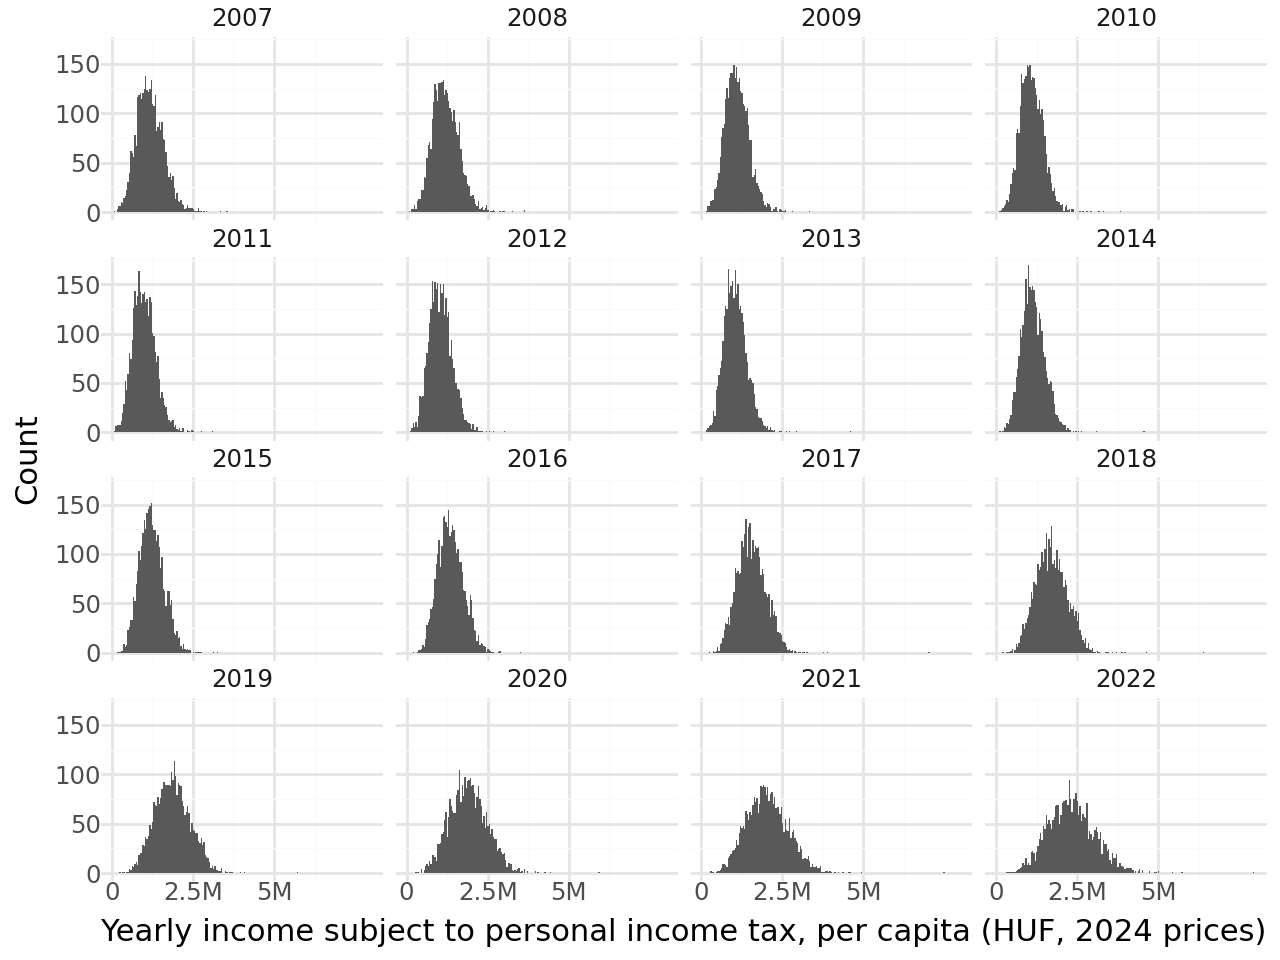

In [92]:
(
    ggplot(df, aes('income_pc'))
    + geom_histogram()
    + facet_wrap('year')
    + theme_minimal()
    #+ scale_y_continuous(breaks = [0, 25, 50])
    + scale_x_continuous(breaks = [0, 2_500_000, 5_000_000], labels = ['0', '2.5M', '5M'])
    + labs(x = 'Yearly income subject to personal income tax, per capita (HUF, 2024 prices)', y = 'Count')
)

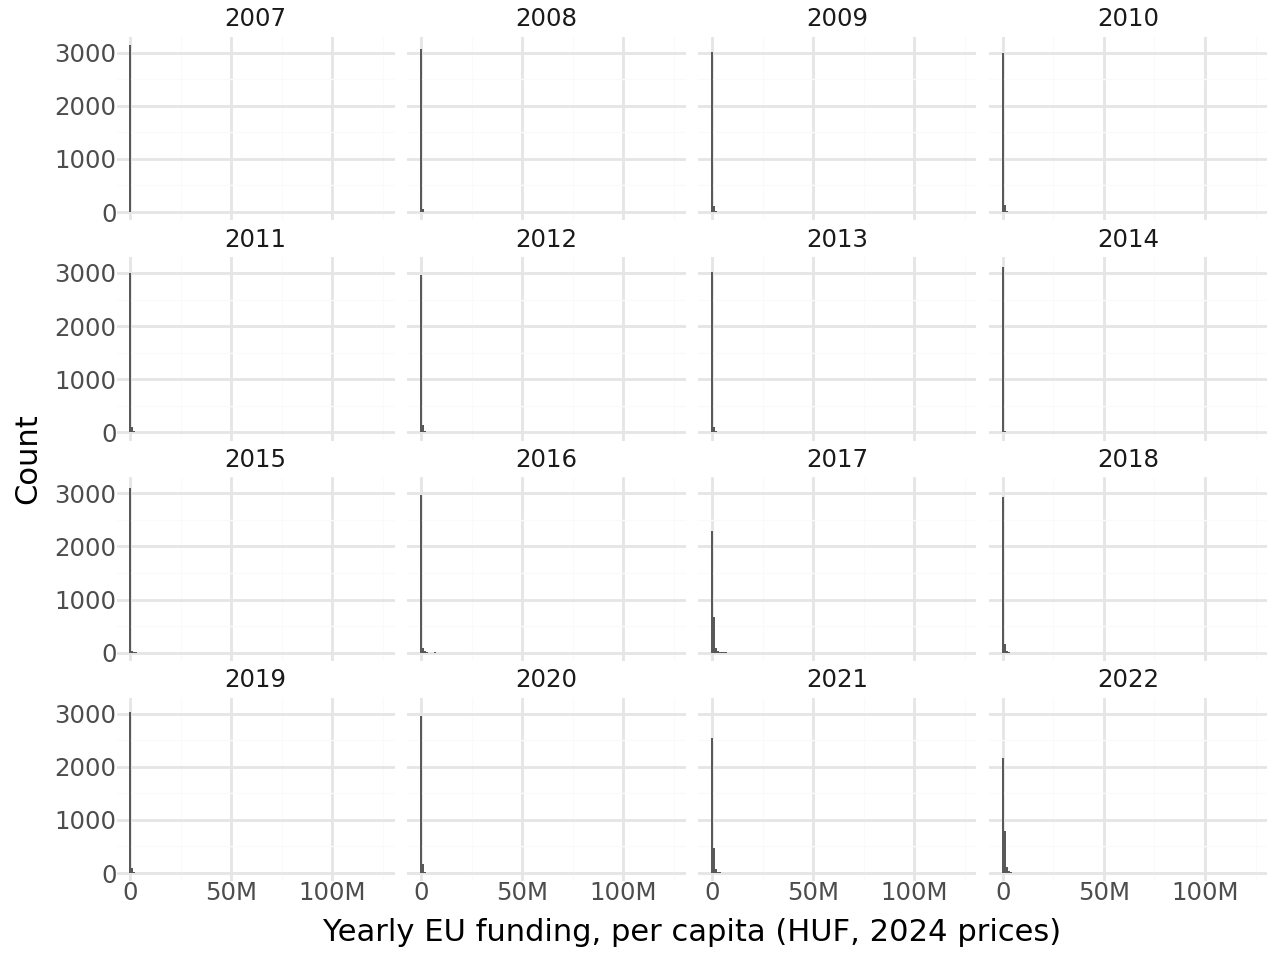

In [93]:
(
    ggplot(df, aes('eu_funding_pc'))
    + geom_histogram(binwidth = 1000000)
    + facet_wrap('year')
    + theme_minimal()
    #+ scale_y_continuous(breaks = [0, 25, 50])
    + scale_x_continuous(breaks = [0, 50_000_000, 100_000_000], labels = ['0', '50M', '100M'])
    + labs(x = 'Yearly EU funding, per capita (HUF, 2024 prices)', y = 'Count')
)

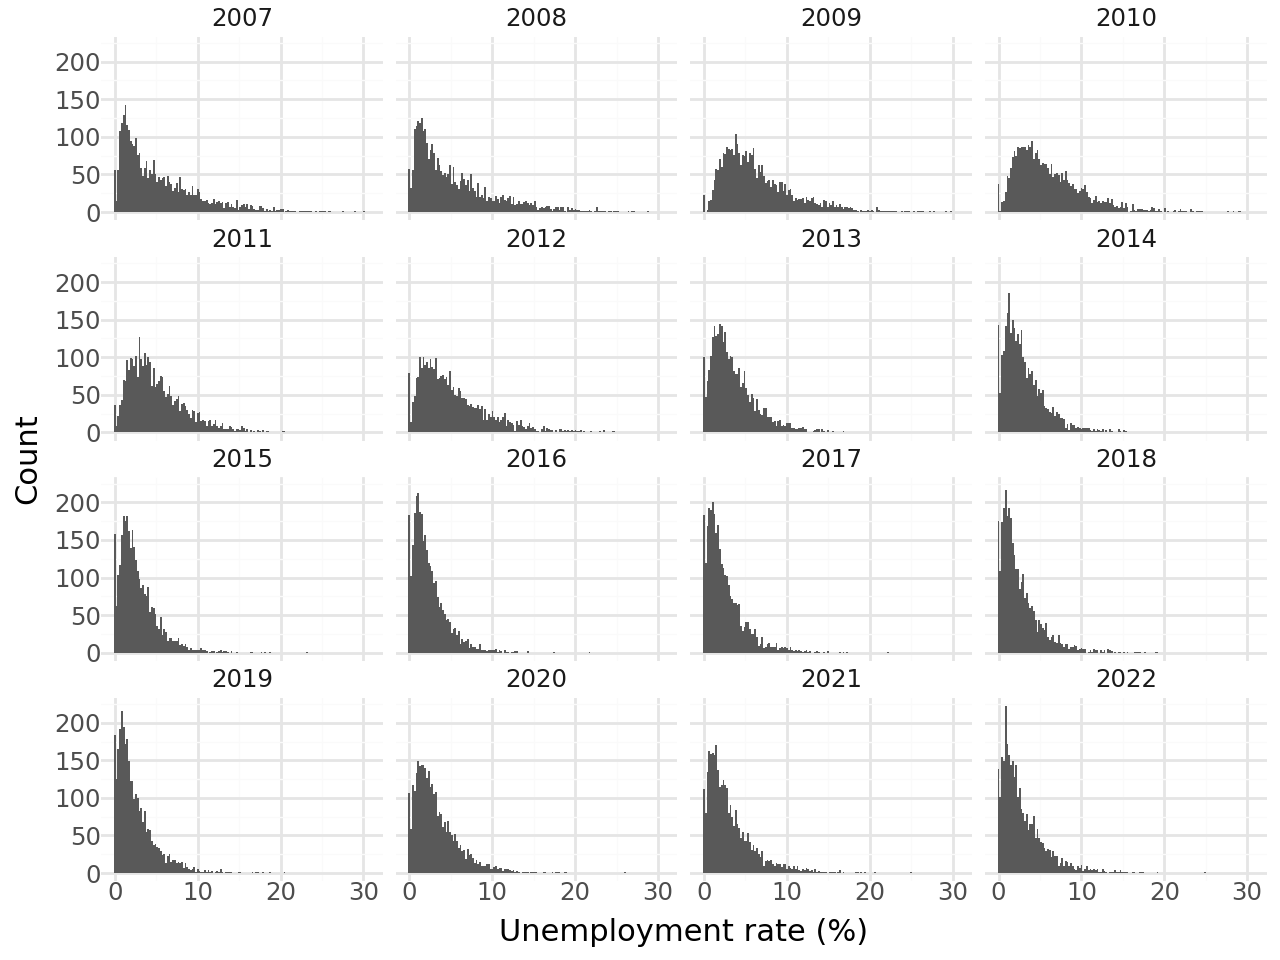

In [94]:
(
    ggplot(df, aes('unemp'))
    + geom_histogram()
    + facet_wrap('year')
    + theme_minimal()
    #+ scale_y_continuous(breaks = [0, 25, 50])
    + scale_x_continuous(breaks = [0, 10, 20, 30])
    + labs(x = 'Unemployment rate (%)', y = 'Count')
)

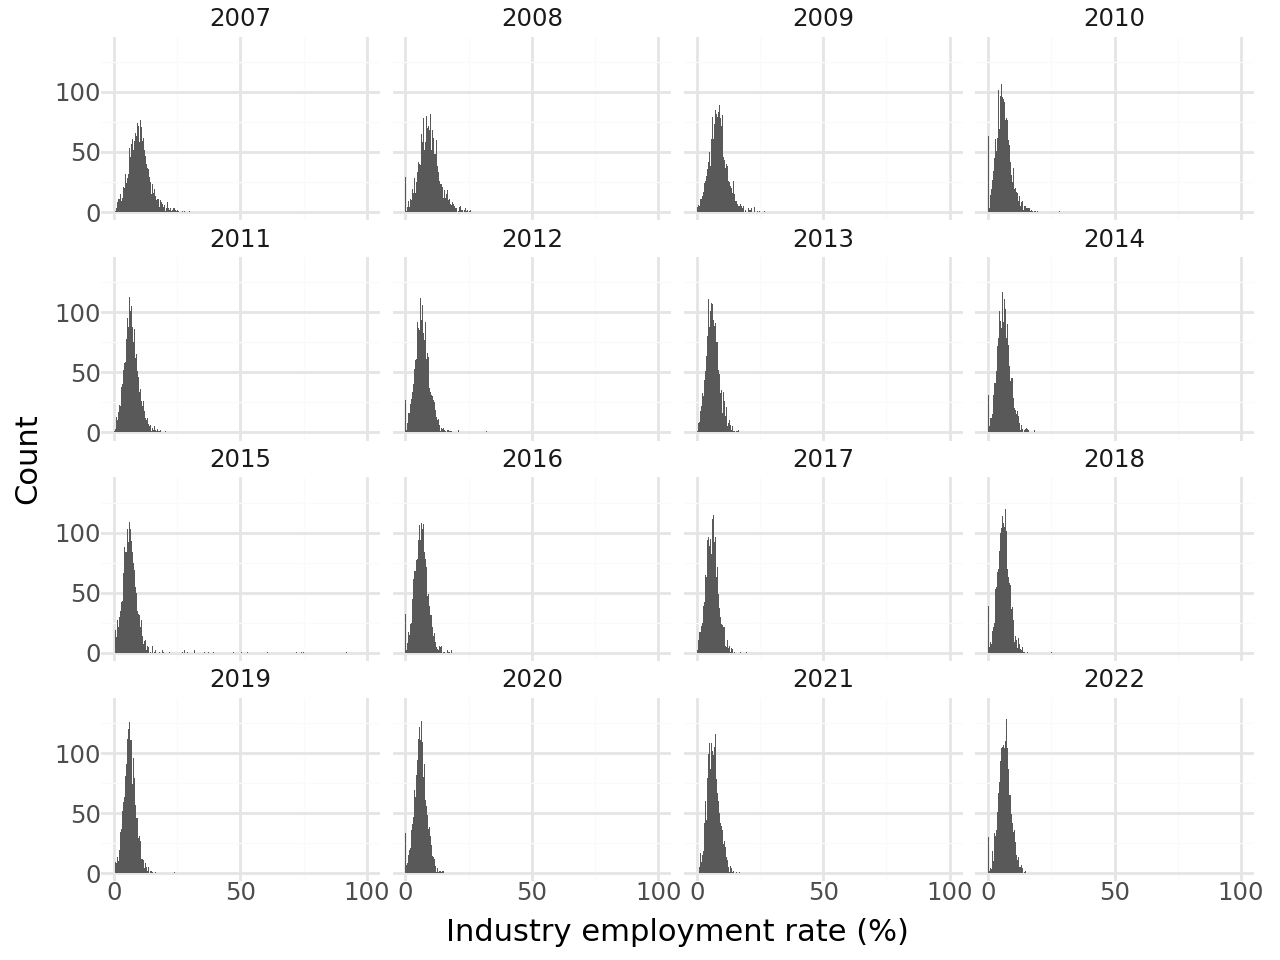

In [95]:
(
    ggplot(df, aes('ind_empl'))
    + geom_histogram()
    + facet_wrap('year')
    + theme_minimal()
    #+ scale_y_continuous(breaks = [0, 25, 50])
    + scale_x_continuous(breaks = [0, 50, 100])
    + labs(x = 'Industry employment rate (%)', y = 'Count')
)

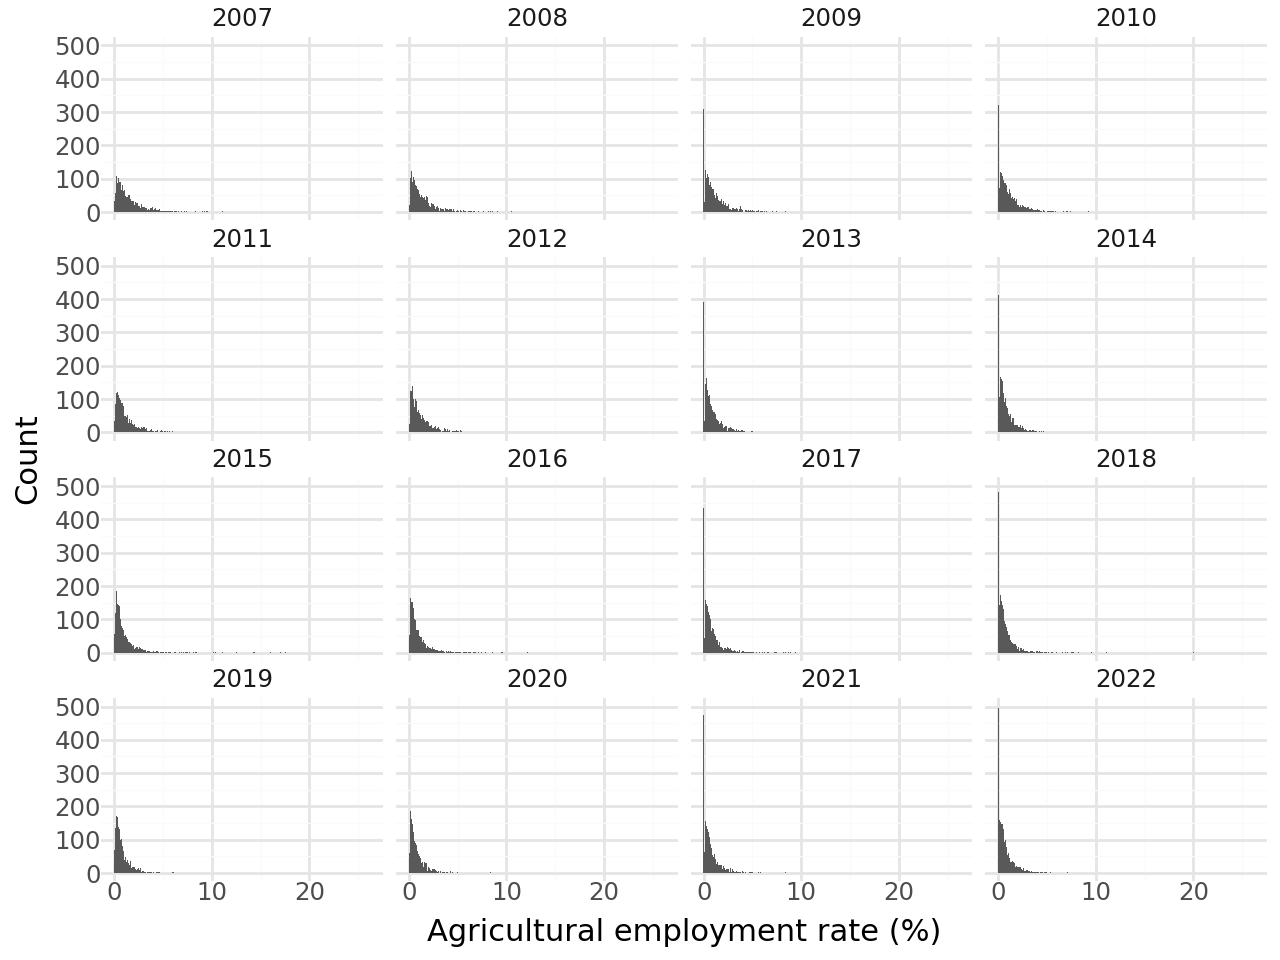

In [96]:
(
    ggplot(df, aes('agr_empl'))
    + geom_histogram()
    + facet_wrap('year')
    + theme_minimal()
    #+ scale_y_continuous(breaks = [0, 25, 50])
    + scale_x_continuous(breaks = [0, 10, 20, 30])
    + labs(x = 'Agricultural employment rate (%)', y = 'Count')
)

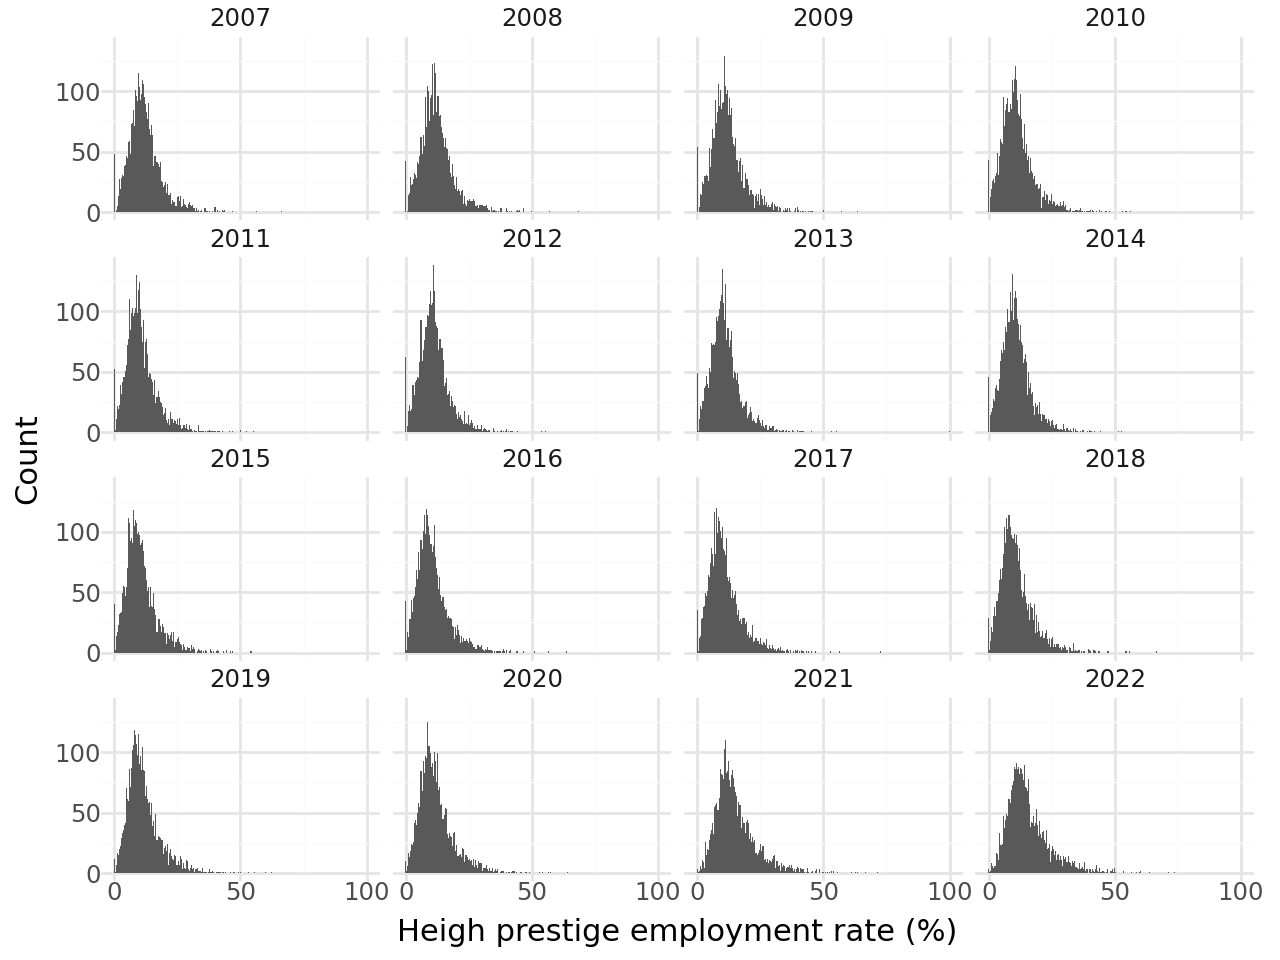

In [97]:
(
    ggplot(df, aes('heigh_prest_empl'))
    + geom_histogram()
    + facet_wrap('year')
    + theme_minimal()
    #+ scale_y_continuous(breaks = [0, 25, 50])
    + scale_x_continuous(breaks = [0, 50, 100])
    + labs(x = 'Heigh prestige employment rate (%)', y = 'Count')
)

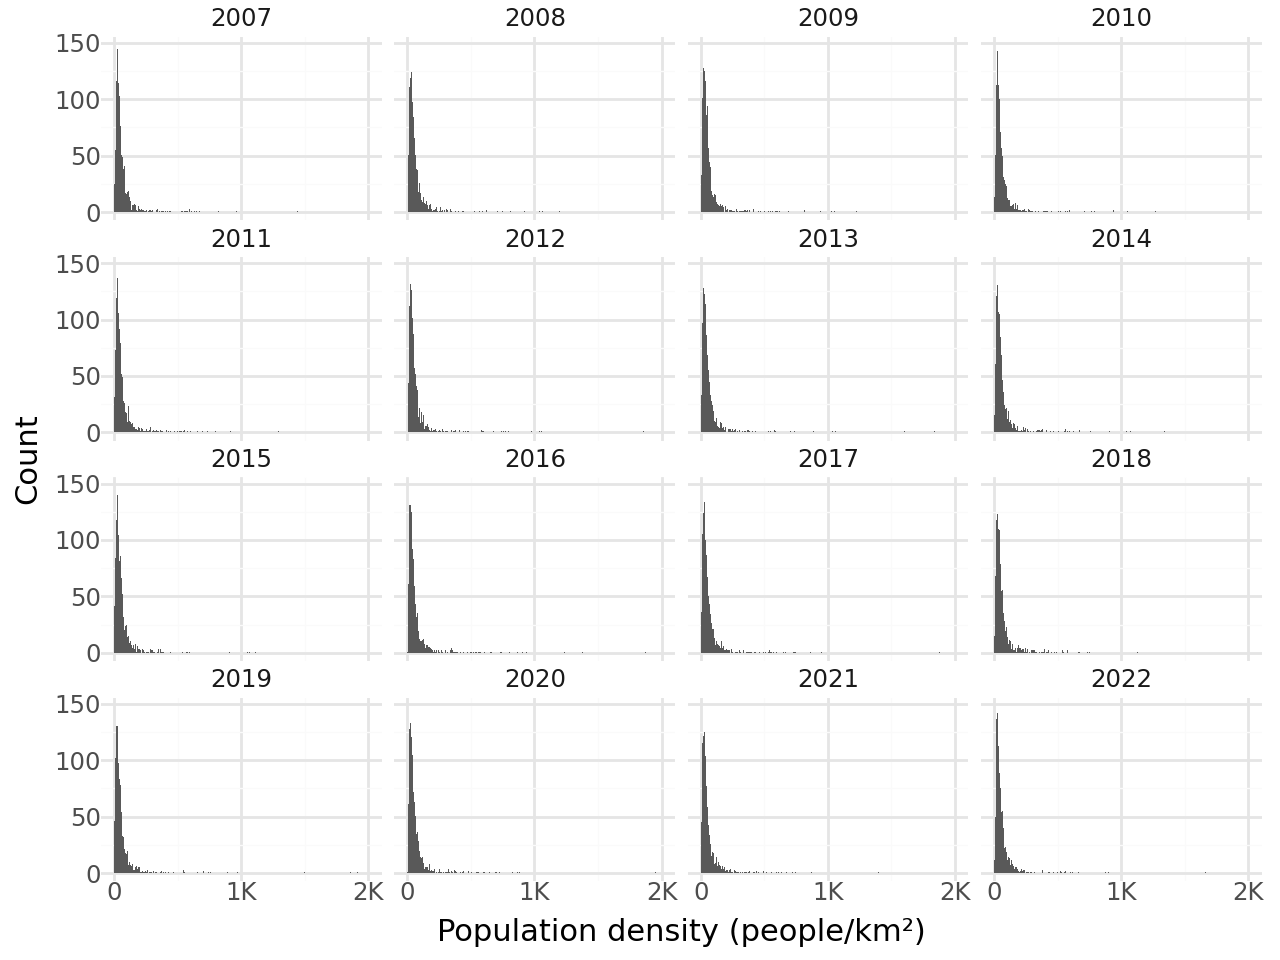

In [98]:
(
    ggplot(df, aes('pop_dense'))
    + geom_histogram()
    + facet_wrap('year')
    + theme_minimal()
    #+ scale_y_continuous(breaks = [0, 25, 50])
    + scale_x_continuous(breaks = [0, 1000, 2000], labels = ['0', '1K', '2K'])
    + labs(x = 'Population density (people/km²)', y = 'Count')
)

In [63]:
(df[df['eu_funding_pc'] == 0].shape[0]/df.shape[0]*100)

39.9201874205845

Let's create some logged variables to account for the skewed distributions - and also create some flags.

In [64]:
df['ln_eu_funding_pc'] = df['eu_funding_pc'].apply(lambda x: np.log(x) if x > 0 else np.log(x+1))
df['no_funding_flag'] = (df['eu_funding_pc'] == 0).astype(int)

df['ln_income_pc'] = df['income_pc'].apply(lambda x: np.log(x))

df['ln_unemp'] = df['unemp'].apply(lambda x: np.log(x) if x > 0 else np.log(df[df['unemp'] > 0].unemp.min()*0.5))
df['unemp_zero_flag'] = (df['unemp'] == 0).astype(int)

df['ln_ind_empl'] = df['ind_empl'].apply(lambda x: np.log(x) if x > 0 else np.log(df[df['ind_empl'] > 0].ind_empl.min()*0.5))
df['ind_empl_zero_flag'] = (df['ind_empl'] == 0).astype(int)

df['ln_agr_empl'] = df['agr_empl'].apply(lambda x: np.log(x) if x > 0 else np.log(df[df['agr_empl'] > 0].agr_empl.min()*0.5))
df['agr_empl_zero_flag'] = (df['agr_empl'] == 0).astype(int)

df['ln_heigh_prest_empl'] = df['heigh_prest_empl'].apply(lambda x: np.log(x) if x > 0 else np.log(df[df['heigh_prest_empl'] > 0].heigh_prest_empl.min()*0.5))
df['heigh_prest_empl_zero_flag'] = (df['heigh_prest_empl'] == 0).astype(int)

df['ln_pop_dense'] = df['pop_dense'].apply(lambda x: np.log(x))

In [65]:
df['f_year'] = df['year'].astype('category')
df['f_muni'] = df['muni'].astype('category')
df = df.set_index(["muni", "year"])

Now, visualize the log-transformed distributions.

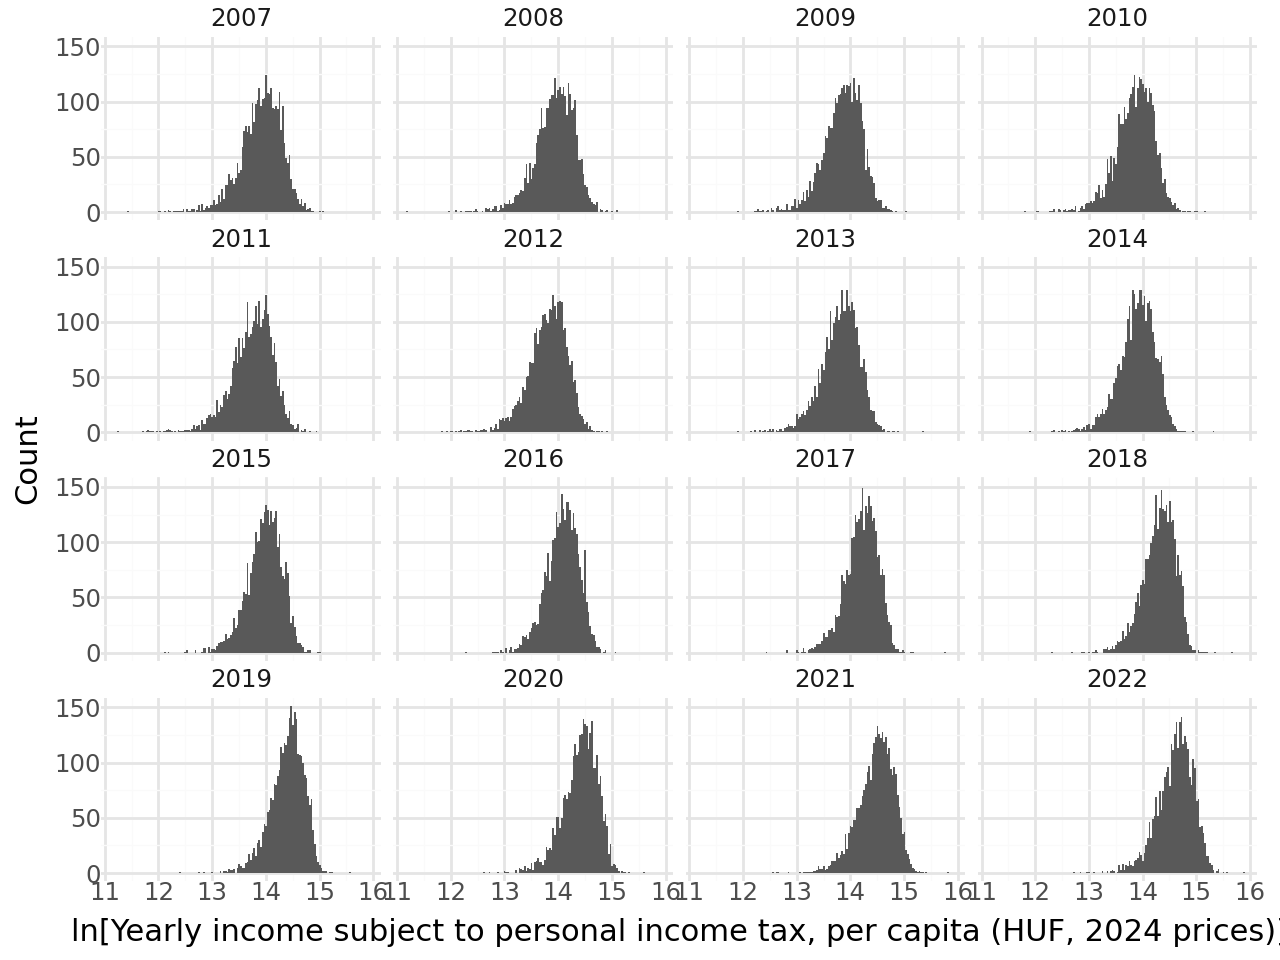

In [104]:
(
    ggplot(df, aes('ln_income_pc'))
    + geom_histogram()
    + facet_wrap('f_year')
    + theme_minimal()
    #+ scale_y_continuous(breaks = [0, 25, 50])
    #+ scale_x_continuous(breaks = [0, 2_500_000, 5_000_000], labels = ['0', '2.5M', '5M'])
    + labs(x = 'ln[Yearly income subject to personal income tax, per capita (HUF, 2024 prices)]', y = 'Count')
)

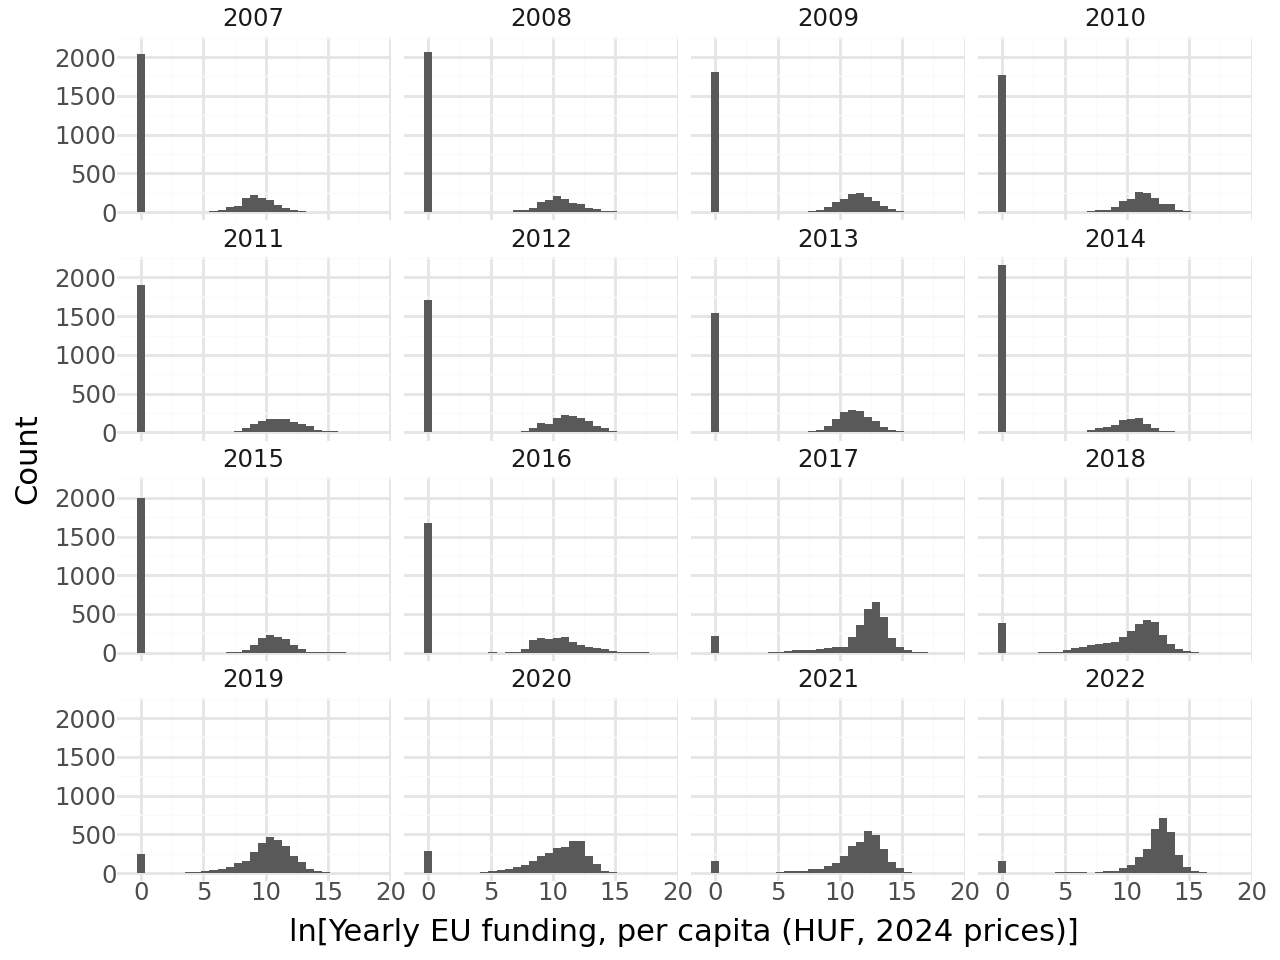

In [105]:
(
    ggplot(df, aes('ln_eu_funding_pc'))
    + geom_histogram()
    + facet_wrap('f_year')
    + theme_minimal()
    #+ scale_y_continuous(breaks = [0, 25, 50])
    #+ scale_x_continuous(breaks = [0, 50_000_000, 100_000_000], labels = ['0', '50M', '100M'])
    + labs(x = 'ln[Yearly EU funding, per capita (HUF, 2024 prices)]', y = 'Count')
)

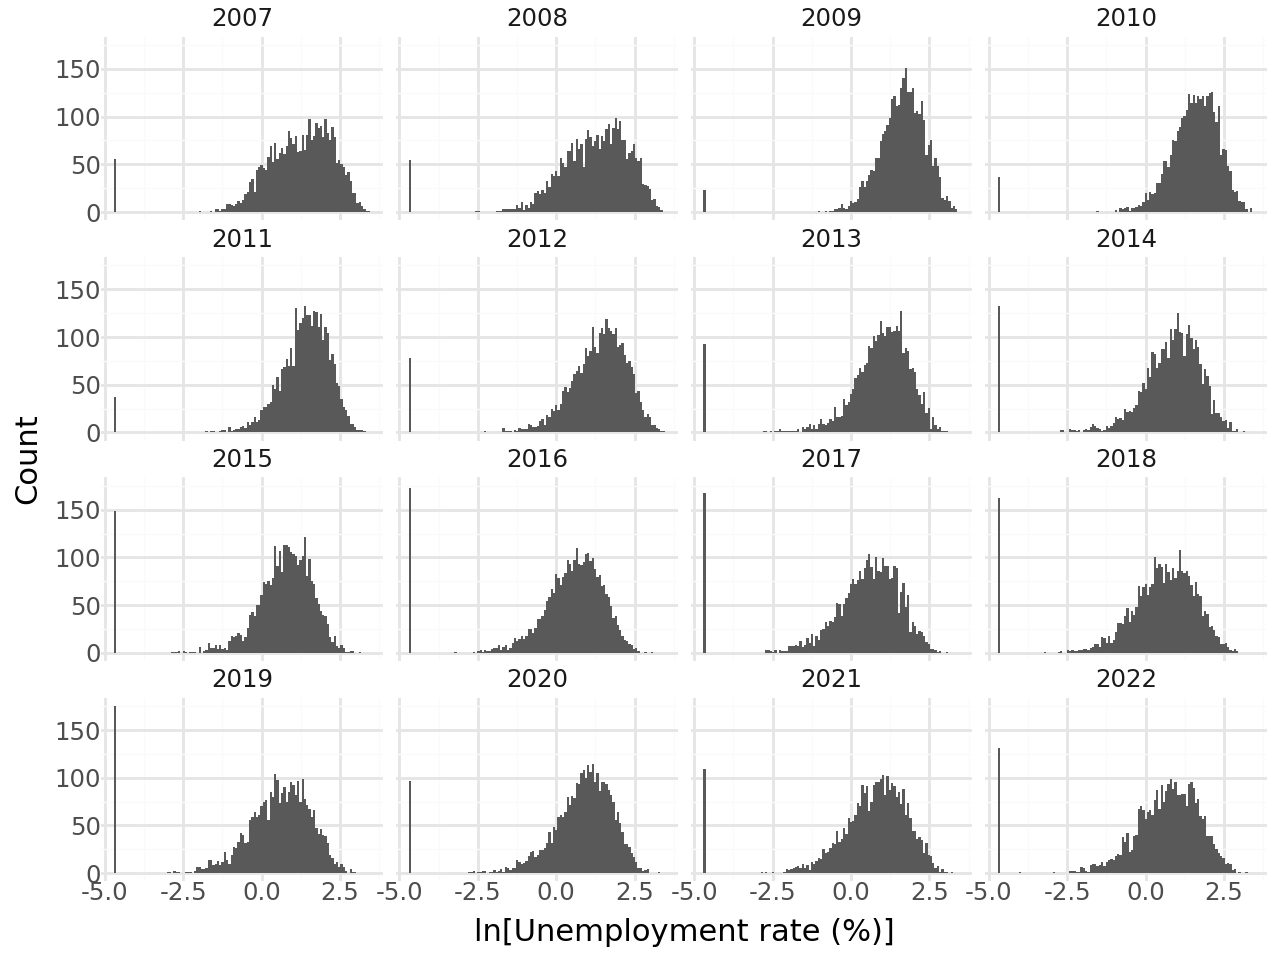

In [106]:
(
    ggplot(df, aes('ln_unemp'))
    + geom_histogram()
    + facet_wrap('f_year')
    + theme_minimal()
    #+ scale_y_continuous(breaks = [0, 25, 50])
    #+ scale_x_continuous(breaks = [0, 10, 20, 30])
    + labs(x = 'ln[Unemployment rate (%)]', y = 'Count')
)

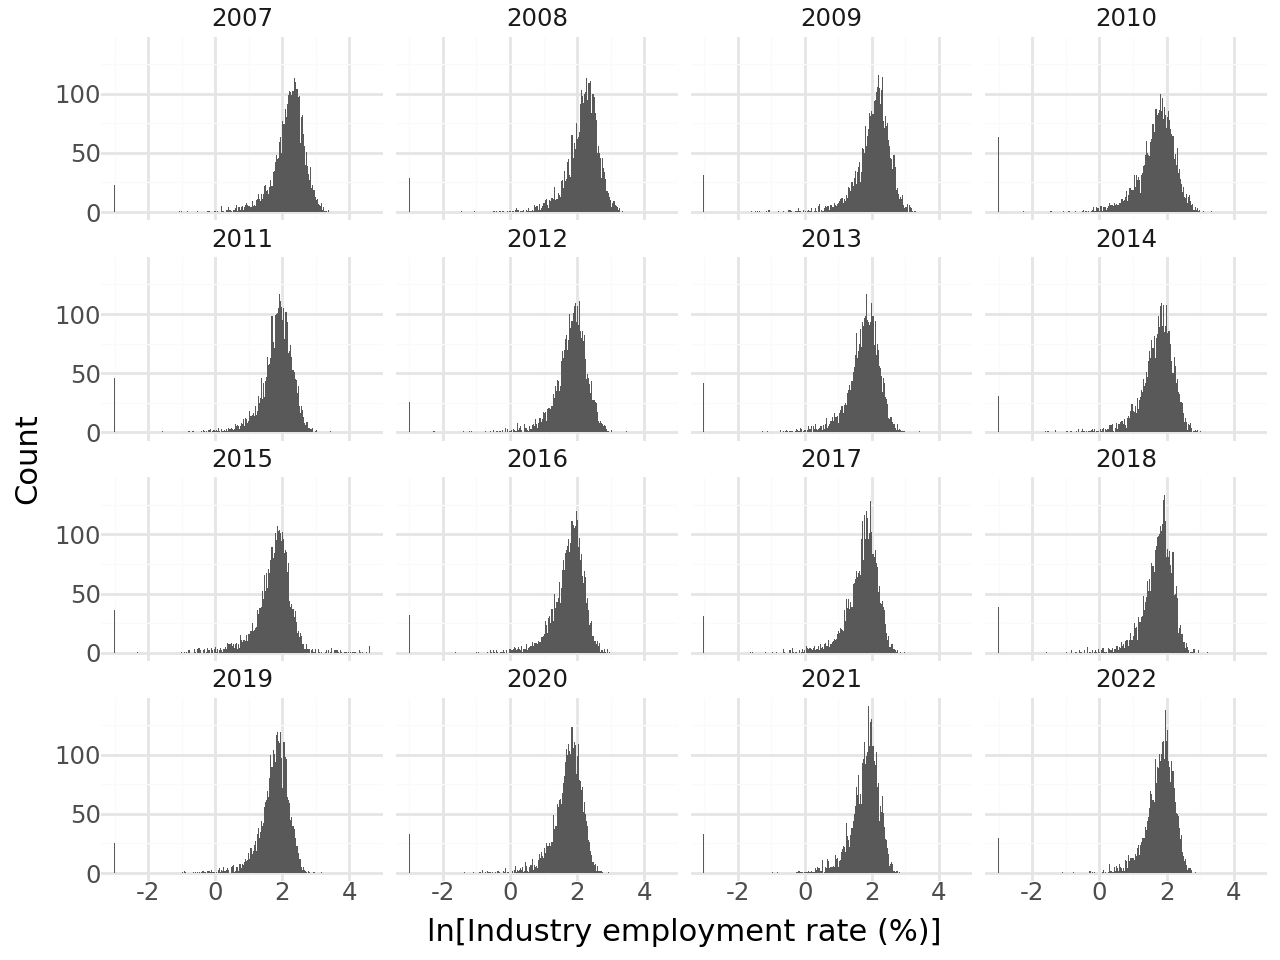

In [107]:
(
    ggplot(df, aes('ln_ind_empl'))
    + geom_histogram()
    + facet_wrap('f_year')
    + theme_minimal()
    #+ scale_y_continuous(breaks = [0, 25, 50])
    #+ scale_x_continuous(breaks = [0, 50, 100])
    + labs(x = 'ln[Industry employment rate (%)]', y = 'Count')
)

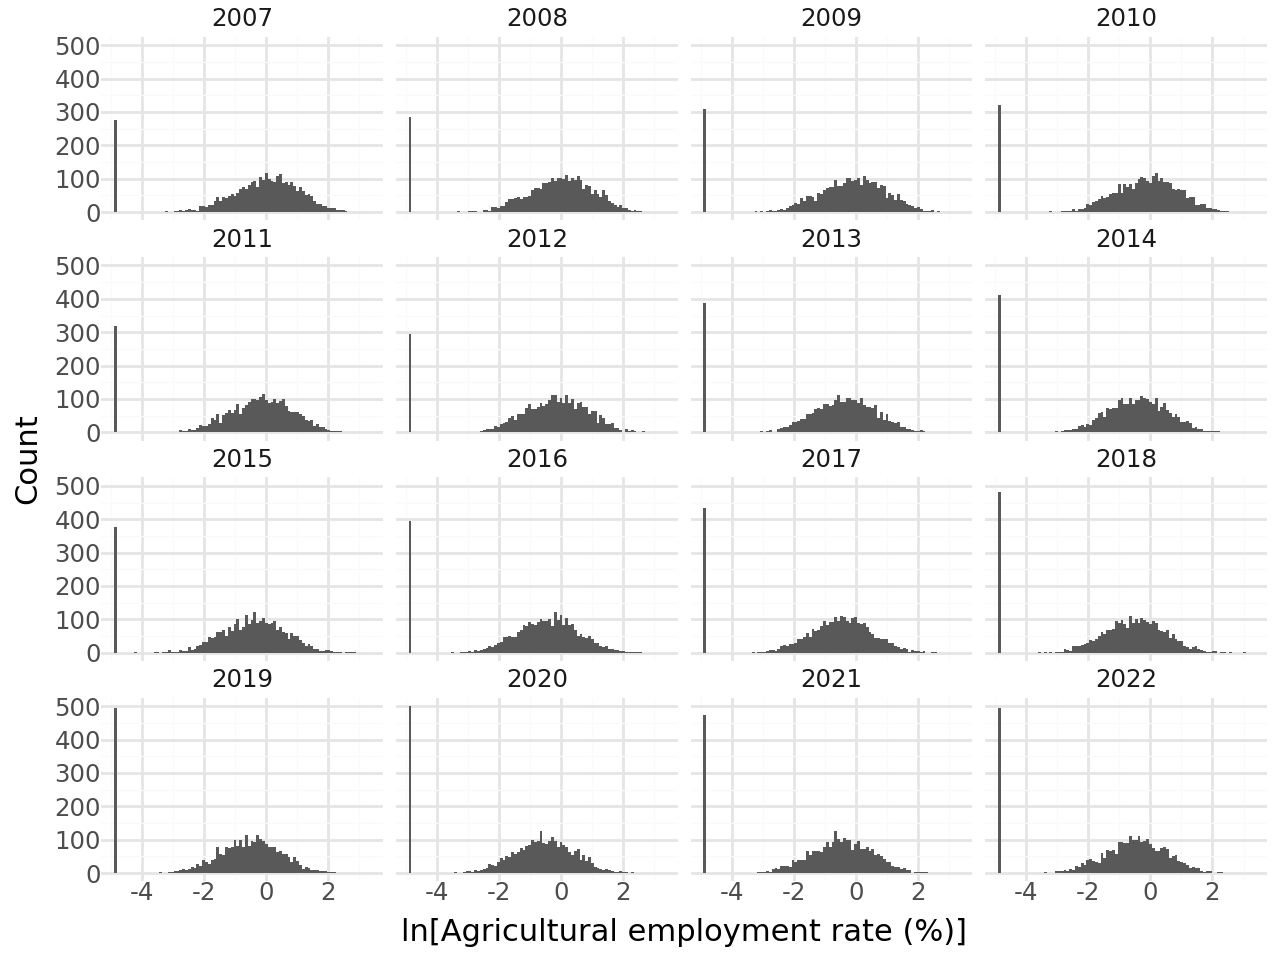

In [108]:
(
    ggplot(df, aes('ln_agr_empl'))
    + geom_histogram()
    + facet_wrap('f_year')
    + theme_minimal()
    #+ scale_y_continuous(breaks = [0, 25, 50])
    #+ scale_x_continuous(breaks = [0, 50, 100])
    + labs(x = 'ln[Agricultural employment rate (%)]', y = 'Count')
)

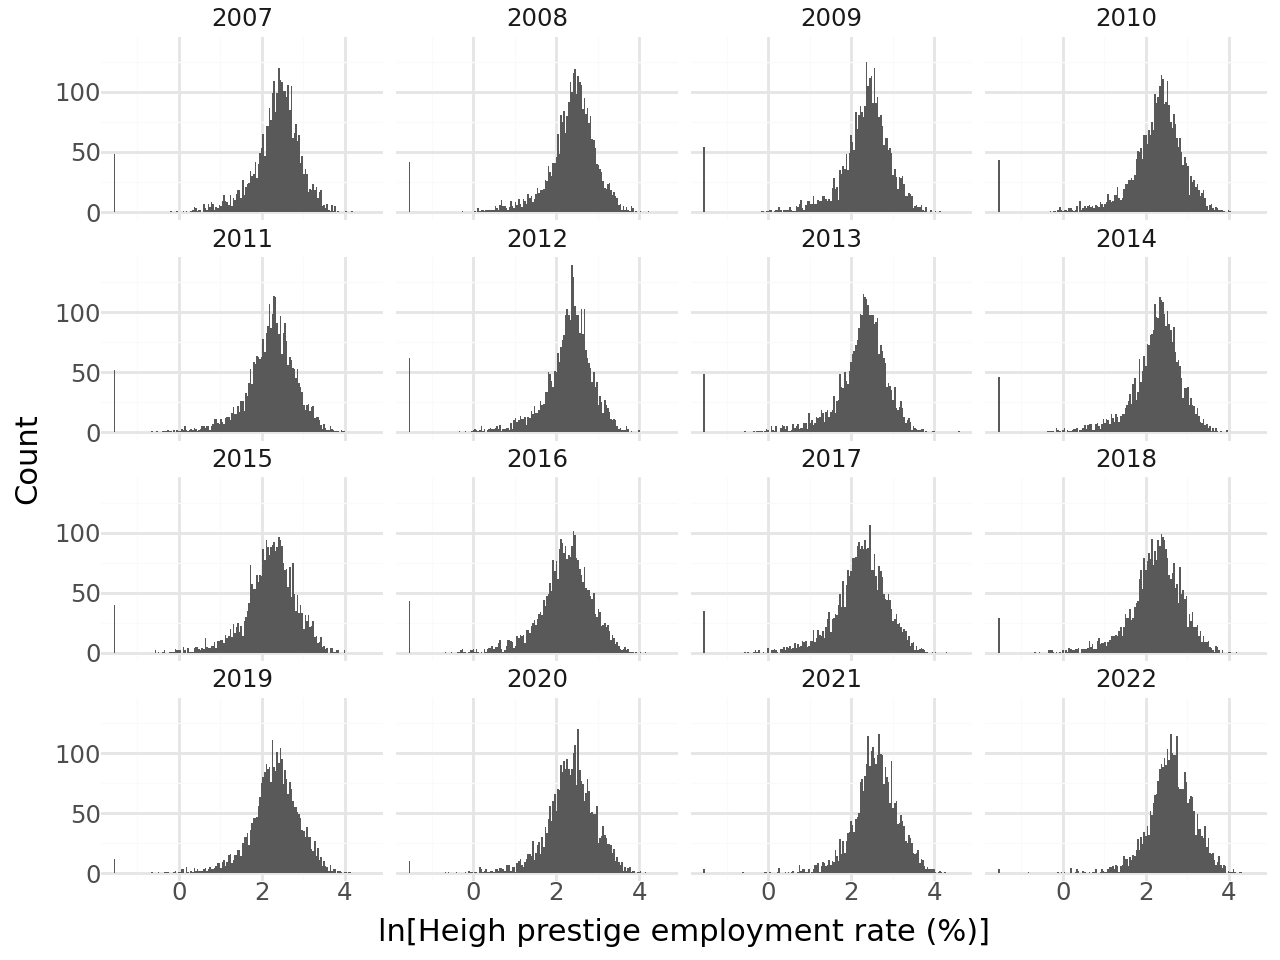

In [109]:
(
    ggplot(df, aes('ln_heigh_prest_empl'))
    + geom_histogram()
    + facet_wrap('f_year')
    + theme_minimal()
    #+ scale_y_continuous(breaks = [0, 25, 50])
    #+ scale_x_continuous(breaks = [0, 50, 100])
    + labs(x = 'ln[Heigh prestige employment rate (%)]', y = 'Count')
)

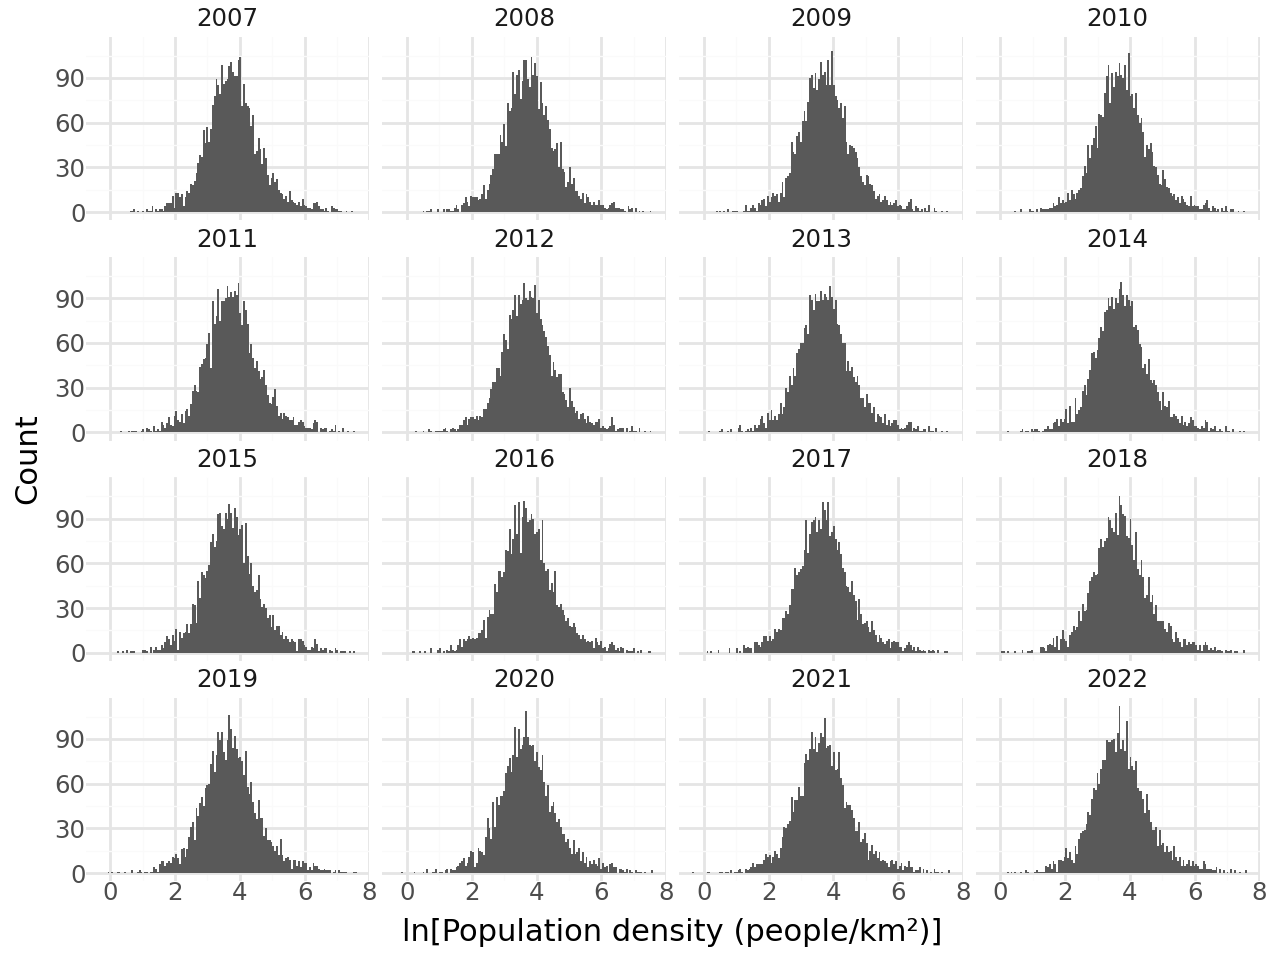

In [110]:
(
    ggplot(df, aes('ln_pop_dense'))
    + geom_histogram()
    + facet_wrap('f_year')
    + theme_minimal()
    #+ scale_y_continuous(breaks = [0, 25, 50])
    #+ scale_x_continuous(breaks = [0, 1000, 2000], labels = ['0', '1K', '2K'])
    + labs(x = 'ln[Population density (people/km²)]', y = 'Count')
)

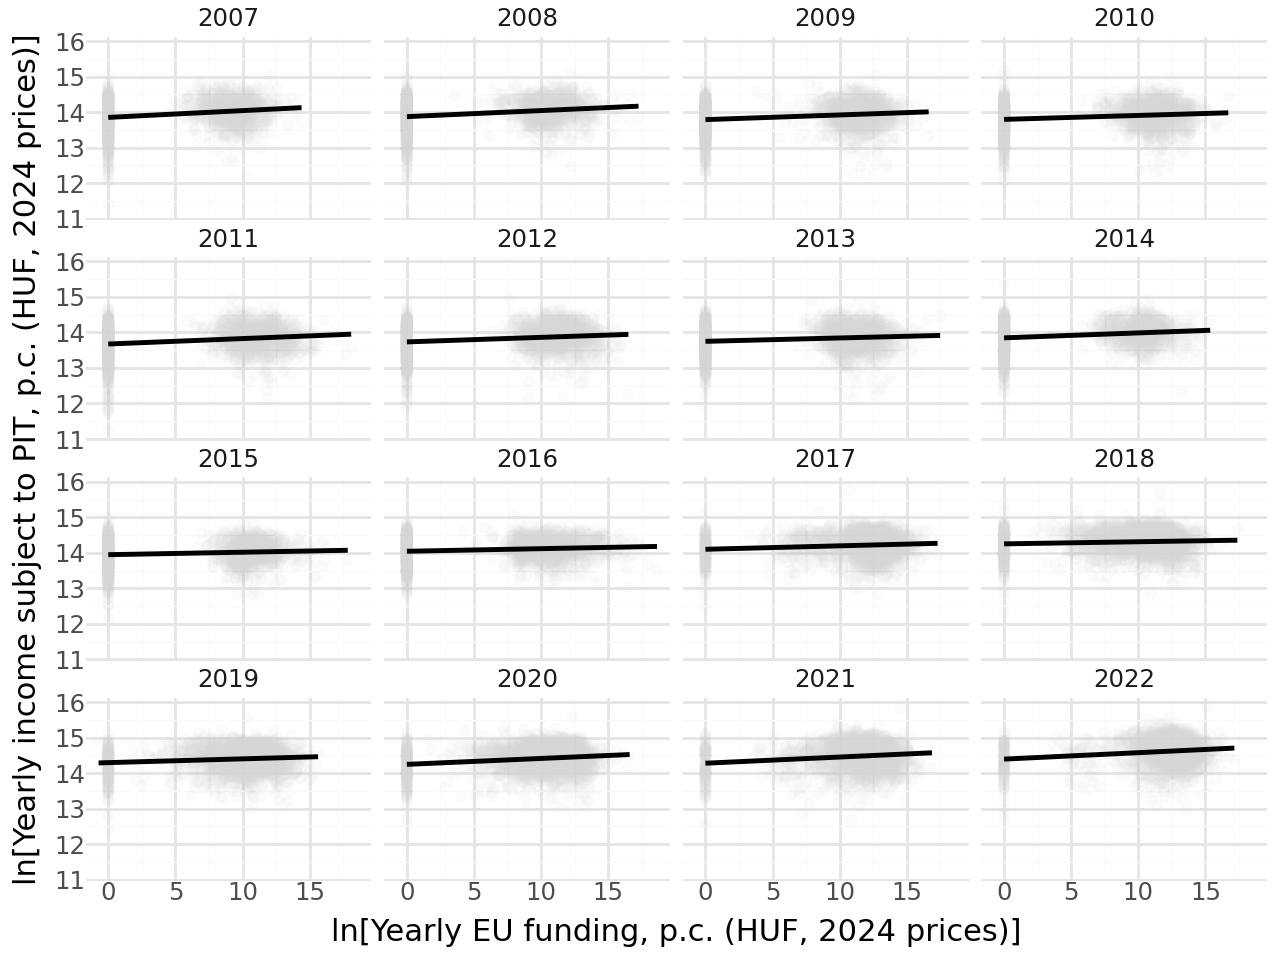

In [111]:
(
    ggplot(df, aes('ln_eu_funding_pc', 'ln_income_pc'))
    + geom_point(alpha = 0.05, color = 'lightgrey')
    + geom_smooth(method = 'lm', se = True)
    + facet_wrap('f_year')
    + theme_minimal()
    + labs(x = 'ln[Yearly EU funding, p.c. (HUF, 2024 prices)]',
          y = 'ln[Yearly income subject to PIT, p.c. (HUF, 2024 prices)]')
)

In [66]:
print(f'T = {len(df.f_year.unique())}')
print(f'N = {len(df.f_muni.unique())}')

T = 16
N = 3148


Adding differences, lags and leads.

In [67]:
df.sort_values(by = ['f_muni', 'f_year'], inplace = True)

In [42]:
vars_to_diff = ['ln_income_pc', 'ln_eu_funding_pc', 'ln_unemp', 'ln_ind_empl', 'ln_agr_empl', 'ln_heigh_prest_empl', 'ln_pop_dense',
               'multi_muni_funding_flag', 'flag_heigh_prest_empl', 'no_funding_flag', 'unemp_zero_flag', 'ind_empl_zero_flag',
               'agr_empl_zero_flag', 'heigh_prest_empl_zero_flag', 'd_ln_eu_funding_pc', 'd_no_funding_flag']

for v in vars_to_diff:
    df[f'd_{v}'] = df.groupby('f_muni')[v].transform('diff')

for v in vars_to_diff:
    for l in [-2,-1,1,2,3]:
        if l < 0:
            df[f'd_{v}_lead{l*-1}'] = df.groupby('f_muni')[f'd_{v}'].shift(l)
        else:
            df[f'd_{v}_lag{l}'] = df.groupby('f_muni')[f'd_{v}'].shift(l)

In [134]:
with open('workfile.dill', 'wb') as f:
    dill.dump(df, f)

# RUN FROM HERE FOR SAVED WORKFILE

In [4]:
with open('workfile.dill', 'rb') as f:
    df = dill.load(f)

Drawing a causal graph for the report.

In [3]:
dot = graphviz.Digraph('dag', comment='Causal DAG', engine = 'dot')
dot.node('EUF', 'EU funding p.c.')
dot.node('INC', 'Income p.c.')
dot.node('UNEMP', 'Unemployment')
dot.node('IND', 'Industry employment')
dot.node('AGR', 'Agric. employment')
dot.node('HPR', 'Heigh prest. empl.')
dot.node('PDENSE', 'Population density')
dot.node('POL', 'Pro-government')
dot.node('BGR', 'Business revenue growth')
dot.node('INFR', 'Infrastructure quality')
dot.node('ECA', 'Economic activity')
dot.node('EDUC', 'Education levels')
dot.node('SPILL', 'Regional spillovers')
dot.node('EUCYCL', 'EU funding cycles')
dot.node('BURQL', 'Bureaucratic quality')
dot.node('MSPE', 'Municipality spending')

In [5]:
dot.edge('EUF', 'INC', label='+')
dot.edge('EUF', 'BGR', label='+')
dot.edge('EUF', 'INFR', label='+')
dot.edge('BGR', 'INC', label='+')
dot.edge('INFR', 'ECA', label='+')
dot.edge('ECA', 'INC', label='+')
dot.edge('UNEMP', 'EUF', label='+')
dot.edge('UNEMP', 'INC', label='–')
dot.edge('IND', 'EUF', label='?')
dot.edge('IND', 'INC', label='?')
dot.edge('AGR', 'EUF', label='+')
dot.edge('AGR', 'INC', label='–')
dot.edge('HPR', 'EUF', label='–')
dot.edge('HPR', 'INC', label='+')
dot.edge('PDENSE', 'EUF', label='+')
dot.edge('PDENSE', 'INC', label='+')
dot.edge('SPILL', 'EUF', label='+')
dot.edge('SPILL', 'INC', label='+')
dot.edge('EDUC', 'EUF', label='+')
dot.edge('EDUC', 'INC', label='+')
dot.edge('BURQL', 'EUF', label='+')
dot.edge('BURQL', 'INC', label='+')
dot.edge('INC', 'POL', label='+')
dot.edge('POL', 'EUF', label='+')
dot.edge('EUCYCL', 'EUF', label='?')
dot.edge('EUF', 'MSPE', label='+')
dot.edge('INC', 'MSPE', label='+')
dot.format = 'svg'

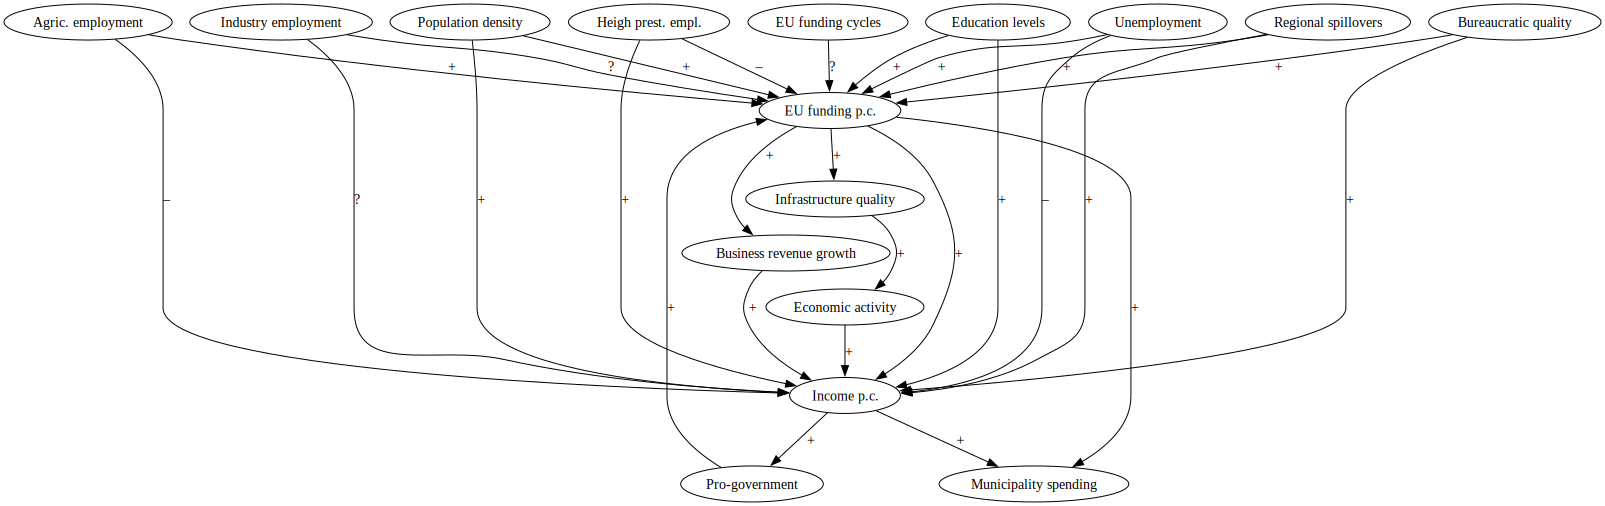

In [7]:
dot.render()
dot

Creating a function to more easily construct regression formulas.

In [6]:
def formula_constructor(y, x, diffs=False, lags=0, leads=0, time_effects=False, cumul=False):  
    formula_parts = []
    
    # Apply first differences if specified
    if diffs:
        y = f"d_{y}"
        x = [f"d_{var}" for var in x]
    
    formula_parts.extend(x)
    
    # Add lags and leads
    for var in x:
        if cumul and var == "d_ln_eu_funding_pc":
            formula_parts.append(f"d_ln_eu_funding_pc_lag{lags}")
            formula_parts.append("d_d_ln_eu_funding_pc")
            for l in range(1, lags):
                formula_parts.append(f"d_d_ln_eu_funding_pc_lag{l}")
        elif cumul and var == "d_no_funding_flag":
            formula_parts.append(f"d_no_funding_flag_lag{lags}")
            formula_parts.append("d_d_no_funding_flag")
            for l in range(1, lags):
                formula_parts.append(f"d_d_no_funding_flag_lag{l}")            
        else:
            for l in range(1, lags + 1):
                formula_parts.append(f"{var}_lag{l}")
            for l in range(1, leads + 1):
                formula_parts.append(f"{var}_lead{l}")
    
    # Add time fixed effects if specified
    if time_effects:
        formula_parts.append("f_year")

    if cumul:
        formula_parts = [x for x in formula_parts if x not in ['d_ln_eu_funding_pc', 'd_no_funding_flag']]
    
    # Construct formula
    formula = f"{y} ~ " + " + ".join(formula_parts)
    
    return formula


In [10]:
funding_vars = ['ln_eu_funding_pc', 'no_funding_flag', 'multi_muni_funding_flag']
confounders = ['ln_unemp', 'ln_agr_empl', 'ln_heigh_prest_empl', 'ln_pop_dense']
confounder_flags = ['flag_heigh_prest_empl', 'unemp_zero_flag', 'ind_empl_zero_flag', 'agr_empl_zero_flag', 'heigh_prest_empl_zero_flag']

Now let's estimate some regression models. All models will be estimated with and without confounders. All FD models will be estimated with simple lags and cumulative effects as well. All models are weighted by population.

Simple OLS in a random year.

In [49]:
m1_data = df[df['f_year'] == 2016]
m1 = smf.wls(formula_constructor('ln_income_pc', funding_vars),
             data = m1_data, weights = m1_data['pop']).fit(cov_type = 'HC1')

In [51]:
m1_c = smf.wls(formula_constructor('ln_income_pc', funding_vars + confounders + confounder_flags),
             data = m1_data, weights = m1_data['pop']).fit(cov_type = 'HC1')

FD with time effects.

In [53]:
m = smf.wls(formula_constructor('ln_income_pc', funding_vars,
                                diffs = True, time_effects = True), df, weights = df['pop'])
m2 = m.fit(
    cov_type="cluster",
    cov_kwds={"groups": df.loc[m.data.row_labels, "f_muni"]},
)

In [55]:
m = smf.wls(formula_constructor('ln_income_pc', funding_vars + confounders + confounder_flags,
                                diffs = True, time_effects = True), df, weights = df['pop'])
m2_c = m.fit(
    cov_type="cluster",
    cov_kwds={"groups": df.loc[m.data.row_labels, "f_muni"]},
)

FD with 3 lags.

In [57]:
m = smf.wls(formula_constructor('ln_income_pc', funding_vars,
                                diffs = True, lags = 3, time_effects = True), df, weights = df['pop'])
m3 = m.fit(
    cov_type="cluster",
    cov_kwds={"groups": df.loc[m.data.row_labels, "f_muni"]},
)

In [59]:
m = smf.wls(formula_constructor('ln_income_pc', funding_vars, 
                                diffs = True, lags = 3, cumul = True, time_effects = True), df, weights = df['pop'])
m3_cumul = m.fit(
    cov_type="cluster",
    cov_kwds={"groups": df.loc[m.data.row_labels, "f_muni"]},
)

In [61]:
m = smf.wls(formula_constructor('ln_income_pc', funding_vars + confounders + confounder_flags,
                                diffs = True, lags = 3, time_effects = True), df, weights = df['pop'])
m3_c = m.fit(
    cov_type="cluster",
    cov_kwds={"groups": df.loc[m.data.row_labels, "f_muni"]},
)

In [63]:
m = smf.wls(formula_constructor('ln_income_pc', funding_vars + confounders + confounder_flags,
                                diffs = True, lags = 3, cumul = True, time_effects = True), df, weights = df['pop'])
m3_c_cumul = m.fit(
    cov_type="cluster",
    cov_kwds={"groups": df.loc[m.data.row_labels, "f_muni"]},
)

FD with 3 lags and 2 leads.

In [65]:
m = smf.wls(formula_constructor('ln_income_pc', funding_vars,
                                diffs = True, lags = 3, leads = 2, time_effects = True), df, weights = df['pop'])
m4 = m.fit(
    cov_type="cluster",
    cov_kwds={"groups": df.loc[m.data.row_labels, "f_muni"]},
)

In [67]:
m = smf.wls(formula_constructor('ln_income_pc', funding_vars, 
                                diffs = True, lags = 3, leads = 2, cumul = True, time_effects = True), df, weights = df['pop'])
m4_cumul = m.fit(
    cov_type="cluster",
    cov_kwds={"groups": df.loc[m.data.row_labels, "f_muni"]},
)

In [71]:
m = smf.wls(formula_constructor('ln_income_pc', funding_vars + confounders + confounder_flags,
                                diffs = True, lags = 3, leads = 2, time_effects = True), df, weights = df['pop'])
m4_c = m.fit(
    cov_type="cluster",
    cov_kwds={"groups": df.loc[m.data.row_labels, "f_muni"]},
)

In [73]:
m = smf.wls(formula_constructor('ln_income_pc', funding_vars + confounders + confounder_flags,
                                diffs = True, lags = 3, leads = 2, cumul = True, time_effects = True), df, weights = df['pop'])
m4_c_cumul = m.fit(
    cov_type="cluster",
    cov_kwds={"groups": df.loc[m.data.row_labels, "f_muni"]},
)

FE models.

In [75]:
m5 = PanelOLS.from_formula(formula_constructor('ln_income_pc', funding_vars, time_effects=True) + ' + EntityEffects',
                           df, weights = df['pop']).fit(cov_type="clustered", cluster_entity=True)

In [77]:
m5_c = PanelOLS.from_formula(formula_constructor('ln_income_pc', funding_vars + confounders + confounder_flags,
                                                 time_effects=True) + ' + EntityEffects',
                           df, weights = df['pop']).fit(cov_type="clustered", cluster_entity=True)

In [79]:
log_log_models = [m1, m1_c, m2, m2_c, m3, m3_cumul, m3_c, m3_c_cumul, m4, m4_cumul, m4_c, m4_c_cumul, m5, m5_c]

In [81]:
sg = Stargazer(log_log_models)
sg.covariate_order(['ln_eu_funding_pc', 'd_ln_eu_funding_pc', 'd_ln_eu_funding_pc_lag1', 'd_ln_eu_funding_pc_lag2', 'd_ln_eu_funding_pc_lag3',
                   'd_ln_eu_funding_pc_lead1', 'd_ln_eu_funding_pc_lead2', 'no_funding_flag', 'd_no_funding_flag', 'd_no_funding_flag_lag1',
                   'd_no_funding_flag_lag2', 'd_no_funding_flag_lag3', 'd_no_funding_flag_lead1', 'd_no_funding_flag_lead2',
                   'multi_muni_funding_flag', 'd_multi_muni_funding_flag', 'd_multi_muni_funding_flag_lag1', 'd_multi_muni_funding_flag_lag2',
                   'd_multi_muni_funding_flag_lag3', 'd_multi_muni_funding_flag_lead1', 'd_multi_muni_funding_flag_lead2'])

In [83]:
sg.significant_digits(5)

In [85]:
sg

In [87]:
print('FE')
print(m5.rsquared_inclusive)
print(m5.rsquared_within)

print('FE contr.')
print(m5_c.rsquared_inclusive)
print(m5_c.rsquared_within)

FE
0.9758042634819966
0.9463001462913889
FE contr.
0.9768703072237096
0.9486661165495945


In [89]:
m1_data = df[df['f_year'] == 2016]
d_m1 = smf.wls(formula_constructor('ln_income_pc', ['no_funding_flag', 'multi_muni_funding_flag']),
             data = m1_data, weights = m1_data['pop']).fit(cov_type = 'HC1')

d_m1_c = smf.wls(formula_constructor('ln_income_pc', ['no_funding_flag', 'multi_muni_funding_flag'] + confounders + confounder_flags),
             data = m1_data, weights = m1_data['pop']).fit(cov_type = 'HC1')

m = smf.wls(formula_constructor('ln_income_pc', ['no_funding_flag', 'multi_muni_funding_flag'],
                                diffs = True, time_effects = True), df, weights = df['pop'])
d_m2 = m.fit(
    cov_type="cluster",
    cov_kwds={"groups": df.loc[m.data.row_labels, "f_muni"]},
)

m = smf.wls(formula_constructor('ln_income_pc', ['no_funding_flag', 'multi_muni_funding_flag'] + confounders + confounder_flags,
                                diffs = True, time_effects = True), df, weights = df['pop'])
d_m2_c = m.fit(
    cov_type="cluster",
    cov_kwds={"groups": df.loc[m.data.row_labels, "f_muni"]},
)

m = smf.wls(formula_constructor('ln_income_pc', ['no_funding_flag', 'multi_muni_funding_flag'],
                                diffs = True, lags = 3, time_effects = True), df, weights = df['pop'])
d_m3 = m.fit(
    cov_type="cluster",
    cov_kwds={"groups": df.loc[m.data.row_labels, "f_muni"]},
)

m = smf.wls(formula_constructor('ln_income_pc', ['no_funding_flag', 'multi_muni_funding_flag'], 
                                diffs = True, lags = 3, cumul = True, time_effects = True), df, weights = df['pop'])
d_m3_cumul = m.fit(
    cov_type="cluster",
    cov_kwds={"groups": df.loc[m.data.row_labels, "f_muni"]},
)

m = smf.wls(formula_constructor('ln_income_pc', ['no_funding_flag', 'multi_muni_funding_flag'] + confounders + confounder_flags,
                                diffs = True, lags = 3, time_effects = True), df, weights = df['pop'])
d_m3_c = m.fit(
    cov_type="cluster",
    cov_kwds={"groups": df.loc[m.data.row_labels, "f_muni"]},
)

m = smf.wls(formula_constructor('ln_income_pc', ['no_funding_flag', 'multi_muni_funding_flag'] + confounders + confounder_flags,
                                diffs = True, lags = 3, cumul = True, time_effects = True), df, weights = df['pop'])
d_m3_c_cumul = m.fit(
    cov_type="cluster",
    cov_kwds={"groups": df.loc[m.data.row_labels, "f_muni"]},
)

m = smf.wls(formula_constructor('ln_income_pc', ['no_funding_flag', 'multi_muni_funding_flag'],
                                diffs = True, lags = 3, leads = 2, time_effects = True), df, weights = df['pop'])
d_m4 = m.fit(
    cov_type="cluster",
    cov_kwds={"groups": df.loc[m.data.row_labels, "f_muni"]},
)

m = smf.wls(formula_constructor('ln_income_pc', ['no_funding_flag', 'multi_muni_funding_flag'], 
                                diffs = True, lags = 3, leads = 2, cumul = True, time_effects = True), df, weights = df['pop'])
d_m4_cumul = m.fit(
    cov_type="cluster",
    cov_kwds={"groups": df.loc[m.data.row_labels, "f_muni"]},
)

m = smf.wls(formula_constructor('ln_income_pc', ['no_funding_flag', 'multi_muni_funding_flag'] + confounders + confounder_flags,
                                diffs = True, lags = 3, leads = 2, time_effects = True), df, weights = df['pop'])
d_m4_c = m.fit(
    cov_type="cluster",
    cov_kwds={"groups": df.loc[m.data.row_labels, "f_muni"]},
)

m = smf.wls(formula_constructor('ln_income_pc', ['no_funding_flag', 'multi_muni_funding_flag'] + confounders + confounder_flags,
                                diffs = True, lags = 3, leads = 2, cumul = True, time_effects = True), df, weights = df['pop'])
d_m4_c_cumul = m.fit(
    cov_type="cluster",
    cov_kwds={"groups": df.loc[m.data.row_labels, "f_muni"]},
)

d_m5 = PanelOLS.from_formula(formula_constructor('ln_income_pc', ['no_funding_flag', 'multi_muni_funding_flag'], time_effects=True) + ' + EntityEffects',
                           df, weights = df['pop']).fit(cov_type="clustered", cluster_entity=True)
						   
d_m5_c = PanelOLS.from_formula(formula_constructor('ln_income_pc', ['no_funding_flag', 'multi_muni_funding_flag'] + confounders + confounder_flags,
                                                 time_effects=True) + ' + EntityEffects',
                           df, weights = df['pop']).fit(cov_type="clustered", cluster_entity=True)

In [91]:
log_dummy_models = [d_m1, d_m1_c, d_m2, d_m2_c, d_m3, d_m3_cumul, d_m3_c, d_m3_c_cumul, d_m4, d_m4_cumul, d_m4_c, d_m4_c_cumul, d_m5, d_m5_c]

In [93]:
d_sg = Stargazer(log_dummy_models)
d_sg.covariate_order(['no_funding_flag', 'd_no_funding_flag', 'd_no_funding_flag_lag1',
                   'd_no_funding_flag_lag2', 'd_no_funding_flag_lag3', 'd_no_funding_flag_lead1', 'd_no_funding_flag_lead2',
                   'multi_muni_funding_flag', 'd_multi_muni_funding_flag', 'd_multi_muni_funding_flag_lag1', 'd_multi_muni_funding_flag_lag2',
                   'd_multi_muni_funding_flag_lag3', 'd_multi_muni_funding_flag_lead1', 'd_multi_muni_funding_flag_lead2'])
d_sg.significant_digits(5)

In [95]:
d_sg

In [97]:
print('FE')
print(d_m5.rsquared_inclusive)
print(d_m5.rsquared_within)

print('FE contr.')
print(d_m5_c.rsquared_inclusive)
print(d_m5_c.rsquared_within)

FE
0.975784389271199
0.9462560376025873
FE contr.
0.9768599999197813
0.9486432405890852


In [179]:
df_small = df[df['f_muni'].isin(list(df[(df['f_year'] == 2022) & (df['pop'] < 5000)].f_muni.unique()))]
df_large = df[df['f_muni'].isin(list(df[(df['f_year'] == 2022) & (df['pop'] >= 5000)].f_muni.unique()))]

In [197]:
m = smf.wls(formula_constructor('ln_income_pc', funding_vars + confounders + confounder_flags,
                                diffs = True, lags = 3, time_effects = True), df_small, weights = df_small['pop'])
s_m3_c = m.fit(
    cov_type="cluster",
    cov_kwds={"groups": df_small.loc[m.data.row_labels, "f_muni"]},
)

m = smf.wls(formula_constructor('ln_income_pc', funding_vars + confounders + confounder_flags,
                                diffs = True, lags = 3, cumul = True, time_effects = True), df_small, weights = df_small['pop'])
s_m3_c_cumul = m.fit(
    cov_type="cluster",
    cov_kwds={"groups": df_small.loc[m.data.row_labels, "f_muni"]},
)

m = smf.wls(formula_constructor('ln_income_pc', funding_vars + confounders + confounder_flags,
                                diffs = True, lags = 3, leads = 2, time_effects = True), df_small, weights = df_small['pop'])
s_m4_c = m.fit(
    cov_type="cluster",
    cov_kwds={"groups": df_small.loc[m.data.row_labels, "f_muni"]},
)

m = smf.wls(formula_constructor('ln_income_pc', funding_vars + confounders + confounder_flags,
                                diffs = True, lags = 3, leads = 2, cumul = True, time_effects = True), df_small, weights = df_small['pop'])
s_m4_c_cumul = m.fit(
    cov_type="cluster",
    cov_kwds={"groups": df_small.loc[m.data.row_labels, "f_muni"]},
)

In [201]:
s_sg = Stargazer([s_m3_c, s_m3_c_cumul, s_m4_c, s_m4_c_cumul])
s_sg.covariate_order(['d_ln_eu_funding_pc', 'd_ln_eu_funding_pc_lag1', 'd_ln_eu_funding_pc_lag2', 'd_ln_eu_funding_pc_lag3',
                   'd_ln_eu_funding_pc_lead1', 'd_ln_eu_funding_pc_lead2', 'd_no_funding_flag', 'd_no_funding_flag_lag1',
                   'd_no_funding_flag_lag2', 'd_no_funding_flag_lag3', 'd_no_funding_flag_lead1', 'd_no_funding_flag_lead2',
                   'd_multi_muni_funding_flag', 'd_multi_muni_funding_flag_lag1', 'd_multi_muni_funding_flag_lag2',
                   'd_multi_muni_funding_flag_lag3', 'd_multi_muni_funding_flag_lead1', 'd_multi_muni_funding_flag_lead2'])
s_sg.significant_digits(5)
s_sg

In [203]:
m = smf.wls(formula_constructor('ln_income_pc', ['no_funding_flag', 'multi_muni_funding_flag'] + confounders + confounder_flags,
                                diffs = True, lags = 3, time_effects = True), df_small, weights = df_small['pop'])
ds_m3_c = m.fit(
    cov_type="cluster",
    cov_kwds={"groups": df_small.loc[m.data.row_labels, "f_muni"]},
)

m = smf.wls(formula_constructor('ln_income_pc', ['no_funding_flag', 'multi_muni_funding_flag'] + confounders + confounder_flags,
                                diffs = True, lags = 3, cumul = True, time_effects = True), df_small, weights = df_small['pop'])
ds_m3_c_cumul = m.fit(
    cov_type="cluster",
    cov_kwds={"groups": df_small.loc[m.data.row_labels, "f_muni"]},
)

m = smf.wls(formula_constructor('ln_income_pc', ['no_funding_flag', 'multi_muni_funding_flag'] + confounders + confounder_flags,
                                diffs = True, lags = 3, leads = 2, time_effects = True), df_small, weights = df_small['pop'])
ds_m4_c = m.fit(
    cov_type="cluster",
    cov_kwds={"groups": df_small.loc[m.data.row_labels, "f_muni"]},
)

m = smf.wls(formula_constructor('ln_income_pc', ['no_funding_flag', 'multi_muni_funding_flag'] + confounders + confounder_flags,
                                diffs = True, lags = 3, leads = 2, cumul = True, time_effects = True), df_small, weights = df_small['pop'])
ds_m4_c_cumul = m.fit(
    cov_type="cluster",
    cov_kwds={"groups": df_small.loc[m.data.row_labels, "f_muni"]},
)

In [205]:
ds_sg = Stargazer([ds_m3_c, ds_m3_c_cumul, ds_m4_c, ds_m4_c_cumul])
ds_sg.covariate_order(['d_no_funding_flag', 'd_no_funding_flag_lag1',
                   'd_no_funding_flag_lag2', 'd_no_funding_flag_lag3', 'd_no_funding_flag_lead1', 'd_no_funding_flag_lead2',
                   'd_multi_muni_funding_flag', 'd_multi_muni_funding_flag_lag1', 'd_multi_muni_funding_flag_lag2',
                   'd_multi_muni_funding_flag_lag3', 'd_multi_muni_funding_flag_lead1', 'd_multi_muni_funding_flag_lead2'])
ds_sg.significant_digits(5)
ds_sg

In [207]:
m = smf.wls(formula_constructor('ln_income_pc', funding_vars + confounders + confounder_flags,
                                diffs = True, lags = 3, time_effects = True), df_large, weights = df_large['pop'])
l_m3_c = m.fit(
    cov_type="cluster",
    cov_kwds={"groups": df_large.loc[m.data.row_labels, "f_muni"]},
)

m = smf.wls(formula_constructor('ln_income_pc', funding_vars + confounders + confounder_flags,
                                diffs = True, lags = 3, cumul = True, time_effects = True), df_large, weights = df_large['pop'])
l_m3_c_cumul = m.fit(
    cov_type="cluster",
    cov_kwds={"groups": df_large.loc[m.data.row_labels, "f_muni"]},
)

m = smf.wls(formula_constructor('ln_income_pc', funding_vars + confounders + confounder_flags,
                                diffs = True, lags = 3, leads = 2, time_effects = True), df_large, weights = df_large['pop'])
l_m4_c = m.fit(
    cov_type="cluster",
    cov_kwds={"groups": df_large.loc[m.data.row_labels, "f_muni"]},
)

m = smf.wls(formula_constructor('ln_income_pc', funding_vars + confounders + confounder_flags,
                                diffs = True, lags = 3, leads = 2, cumul = True, time_effects = True), df_large, weights = df_large['pop'])
l_m4_c_cumul = m.fit(
    cov_type="cluster",
    cov_kwds={"groups": df_large.loc[m.data.row_labels, "f_muni"]},
)

In [209]:
l_sg = Stargazer([l_m3_c, l_m3_c_cumul, l_m4_c, l_m4_c_cumul])
l_sg.covariate_order(['d_ln_eu_funding_pc', 'd_ln_eu_funding_pc_lag1', 'd_ln_eu_funding_pc_lag2', 'd_ln_eu_funding_pc_lag3',
                   'd_ln_eu_funding_pc_lead1', 'd_ln_eu_funding_pc_lead2', 'd_no_funding_flag', 'd_no_funding_flag_lag1',
                   'd_no_funding_flag_lag2', 'd_no_funding_flag_lag3', 'd_no_funding_flag_lead1', 'd_no_funding_flag_lead2',
                   'd_multi_muni_funding_flag', 'd_multi_muni_funding_flag_lag1', 'd_multi_muni_funding_flag_lag2',
                   'd_multi_muni_funding_flag_lag3', 'd_multi_muni_funding_flag_lead1', 'd_multi_muni_funding_flag_lead2'])
l_sg.significant_digits(5)
l_sg

In [215]:
m = smf.wls(formula_constructor('ln_income_pc', ['no_funding_flag', 'multi_muni_funding_flag'] + confounders + confounder_flags,
                                diffs = True, lags = 3, time_effects = True), df_large, weights = df_large['pop'])
dl_m3_c = m.fit(
    cov_type="cluster",
    cov_kwds={"groups": df_large.loc[m.data.row_labels, "f_muni"]},
)

m = smf.wls(formula_constructor('ln_income_pc', ['no_funding_flag', 'multi_muni_funding_flag'] + confounders + confounder_flags,
                                diffs = True, lags = 3, cumul = True, time_effects = True), df_large, weights = df_large['pop'])
dl_m3_c_cumul = m.fit(
    cov_type="cluster",
    cov_kwds={"groups": df_large.loc[m.data.row_labels, "f_muni"]},
)

m = smf.wls(formula_constructor('ln_income_pc', ['no_funding_flag', 'multi_muni_funding_flag'] + confounders + confounder_flags,
                                diffs = True, lags = 3, leads = 2, time_effects = True), df_large, weights = df_large['pop'])
dl_m4_c = m.fit(
    cov_type="cluster",
    cov_kwds={"groups": df_large.loc[m.data.row_labels, "f_muni"]},
)

m = smf.wls(formula_constructor('ln_income_pc', ['no_funding_flag', 'multi_muni_funding_flag'] + confounders + confounder_flags,
                                diffs = True, lags = 3, leads = 2, cumul = True, time_effects = True), df_large, weights = df_large['pop'])
dl_m4_c_cumul = m.fit(
    cov_type="cluster",
    cov_kwds={"groups": df_large.loc[m.data.row_labels, "f_muni"]},
)

In [217]:
dl_sg = Stargazer([dl_m3_c, dl_m3_c_cumul, dl_m4_c, dl_m4_c_cumul])
dl_sg.covariate_order(['d_no_funding_flag', 'd_no_funding_flag_lag1',
                   'd_no_funding_flag_lag2', 'd_no_funding_flag_lag3', 'd_no_funding_flag_lead1', 'd_no_funding_flag_lead2',
                   'd_multi_muni_funding_flag', 'd_multi_muni_funding_flag_lag1', 'd_multi_muni_funding_flag_lag2',
                   'd_multi_muni_funding_flag_lag3', 'd_multi_muni_funding_flag_lead1', 'd_multi_muni_funding_flag_lead2'])
dl_sg.significant_digits(5)
dl_sg